<center><h1> Relaxation time analysis from MD simulations </h1> </center> </br>
<center>Version 2.0 , last modified: 7.2.2023</center>

<h3>1. README.yaml creation - basic info on simulations </h3>
In manage_files.py, last modified: 5.2.2023
<h3>2. Removal of water from xtc, tpr, gro for faster analysis </h3>
In manage_files.py, last modified: 5.2.2023
<h3>3. Correlation function calculations</h3>
In relaxation_times.py, last modified: 7.2.2023
<h3>4. Average over correlation functions</h3>
In relaxation_times.py, last modified: 7.2.2023
<h3>5. Spin relaxation times calculations</h3>
In relaxation_times.py, last modified: 7.2.2023 - fix bug in title of plots, fix bug in output saving
<h3>6. Plotting</h3>
In plotting.py, last modified: 7.2.2023

In [1]:
import sys
import numpy as np
from scipy import optimize
import relaxation_times as rt
import manage_files as mf
import plotting as pt
import matplotlib.pyplot as plt
import os
import re
import yaml
import fnmatch
#from numba import jit #

#gyromagnetic ratios for further developmant
# !!! NOTICE!!!
#values taken from matlab code and projecct work and slightly different than those in Wikipedia
#these values are also in the external file --> if change is needed; has to be changed there
#values here in jupyter just for the information and verify, why they are different
#!!! NOTICE END !!!
gammaD=41.695*10**6; #r*s^(-1)*T^(-1)
gammaH=267.513*10**6;
gammaC=67.262*10**6;
gammaN=-27.166*10**6;

/home/ricky/anaconda3/envs/all3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ricky/anaconda3/envs/all3/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


<h3> 1) Create README.yaml file + 2) Remove water </h3>
This part is intended for managing many simulations at the same time. <br>
Or just improving the management of simulations in general.<br>
The README.yaml allows for more efficient analysis later on. <br>
Simulations are expected to be in different subfolders of parent_folder_path.

In [3]:
#help(mf.go_through_simulation)

In [3]:
#help(mf.remove_water)

In [10]:
parent_folder_path="/home/ricky/Documents/from_work/MD/simulations/production_run/"
systems=["111wrr","eElab_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_replica2","red_simulations"] # select only systems which 
                                                     #folder name contains some of these
compress_xtc=False # True/False/Original 
                   #     True - creates tpr, xtc, gro with selection "selection"
                   #     False - creates tpr, gro with the selection, 
                   #             assumes that reduced xtc already exists
                   #     Original - uses original trajectories for correlation function calculation
                   #                slows significantly down the calculations
                    
selection="non-Water"  # at the moment only standard selections that exists in a default index file supported
                 # such as non-Water 
                    
for file in os.listdir(parent_folder_path):
    folder_path = parent_folder_path+os.fsdecode(file)+"/"
    for system in systems:
        if fnmatch.fnmatch(os.fsdecode(file), "*"+system+"*"):
            mf.go_through_simulation(folder_path)
            mf.remove_water(folder_path,selection,compress_xtc)


<h3> 3) Calculate correlation functions </h3>
Code exists and will be soon implemented <br> 
Includes creation of ndx file and calling gromacs for corellation function analysis

<h4>Example use 1 of rt.CalculateCorrelationFunctions</h4>
<br>
No README.yaml exists, user enters gro,xtc,tpr files path <br>
If 42 is returned, be happy, you just obtained <br>
The ultimate answer to life, universe, and everything

In [6]:
#help(rt.CalculateCorrelationFunctions)

In [2]:
output_path="./"    
folder_path="/home/ricky/Documents/from_work/MD/simulations/production_run/111_empty_try/"


begin=0
end=-1
RM_avail=False
atom1="C1"
atom2="H11"
moleculeType="All"
gro="SDS_1_SDS_NA_OPC_solvated_from_local_production_frame_0ns_from_equilibrated_trajectory_every100fs_local_25ps_mahti.gro"
xtc="SDS_1_SDS_NA_OPC_solvated_from_local_production_frame_0ns_from_equilibrated_trajectory_every100fs_local_25ps_mahti_nojump_nosolvent_10ns.xtc"
tpr="SDS_1_SDS_NA_OPC_solvated_from_local_production_frame_0ns_from_equilibrated_trajectory_every100fs_local_25ps_mahti.tpr"


rt.CalculateCorrelationFunctions(folder_path,begin,end,RM_avail,atom1,atom2,moleculeType,output_path,gro,xtc,tpr)

Number of corelation functions to calculate: 1 

Calculatin correlation function 1,  last frame 42


<h4>Example use 2 of rt.CalculateCorrelationFunctions</h4>
<br>
README.yaml exists, use for peptides/proteins <br>


Calculates correlation functions for all the bonds of the same typy within the system. <br>
In the case of multiple same proteins, correlation functions are calculated separately <br>
as thouht for different residues

In [2]:
output_path="./"    
parent_folder_path="/home/ricky/Documents/from_work/MD/simulations/production_run/"
systems=["111vr","eElab_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_replica2","red_simulations"] # select only systems which 
                                                     #folder name contains some of these

begin=-1
end=10000
RM_avail=True
atom1="N"
atom2="HN"
moleculeType="Protein"

for file in os.listdir(parent_folder_path):
    folder_path = parent_folder_path+os.fsdecode(file)+"/"
    for system in systems:
        if fnmatch.fnmatch(os.fsdecode(file), "*"+system+"*"):
            print(os.fsdecode(file))
            rt.CalculateCorrelationFunctions(folder_path,begin,end,RM_avail,atom1,atom2,moleculeType,output_path)
    

eElab_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_replica2
Correlation function for  eElab_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_replica2  already calculated.


<h4>Example use 3 of rt.CalculateCorrelationFunctions by rt.CorrelationFunctionsLipids</h4>
<br>
README.yaml exists, use for lipids/detergents <br>


Calculates correlation functions for all the bonds specified. <br>
If more bonds of the same type exist, it averages over them <br>
Also means that if the same atom names exist for different 
molecules/parts - it creates a problem

In [5]:
#help(rt.CorrelationFunctionsLipids)

In [3]:
output_path="//home/ricky/Documents/from_work/git/NMR_FF_tools/relaxation_times/"    
parent_folder_path="/home/ricky/Documents/from_work/MD/simulations/production_run/"
systems=["111","blue_simulations","red_simulations"] # select only systems which 
                                                     #folder name contains some of these

begin=-1
end=-1
RM_avail=True
moleculeType="All"

CH_bonds=[("C1","H11"),("C2","H21"),("C3","H31"),
("C4","H41"),("C5","H51"),("C6","H61"),
("C7","H71"),("C8","H81"),("C9","H91"),
("C10","H101"),("C11","H111"),("C12","H121")]


rt.CorrelationFunctionsLipids(parent_folder_path,begin,end,RM_avail,moleculeType,output_path,systems,CH_bonds)

<h3> 4) Average over Correlation functions </h3>

Code exists, I will add it soon

<h3> 5) Get spin relaxation data and time scales of dynamics </h3>

Spin relaxation calculation parts adapted from scripts 
by  H. Antila,  S. Ollila and T. Ferreira <br>
saved in relaxation_times.py

<h4> 3.1) Set analysis parameters</h4>

In [2]:
"""Parameters to be specified by the user"""
OP=0 # order parameter
smallest_corr_time=-1 # enter in log scale -3 fs; 0 ps; 3 ns; 6 us;
biggest_corr_time=4 # same as above
N_exp_to_fit=100 # number of exponential functions to be fitted between the samlles and biggest corr time
analyze=1/10 # the proportin of correlation data to be used for fitting, ex. 1/2 uses first half of the data
magnetic_field=2.35 # 5.99 # 8.49 T (values used in SDS paper, J.Chem. Soc.,, Faraday Trans. 1, 1988, 84(12), 4475-4486)
#magn_field_MHz=850 # for values in MHz
#magnetic_field=magn_field_MHz*2*np.pi/gammaH*10**6
nuclei="2H" #nuclei to calculate: 2H-deutherium; 13C - carbon; 15N - nitrogen 

<h4>3.2) Set paths and names</h4>

In [3]:
parent_folder_path="../../CorysPeptides/correlation_functions/peptides/raw/"   # for option 3 of calculation (not needed for option 2)
systems=[""]               # for opt 3, to further narrow down selection
                           # only takes the subfolders that contain the strings in the list
    
folder_path="../../CorysPeptides/correlation_functions/SDS/average_over_SDS/empty_60SDS_10fsSF_replica1_81A/" # for opt 2, not needed for otp 3

output_name="empty_60SDS_10fsSF_replica1_81A" # serves as a prefix for yaml output files
                           # if None and README_correl.yaml exists, xtc file name is used
                           #delete the '=None' in the last argument of rt.analyze_all_in_folder(...,output_name=None)
                           # if you wish for the name here to be used
                           # otherwise uses the name of the xtc file, if README_correl.yaml exists
                           # README_correl.yaml exists if correlation functions were 
                           # calculated by this script
                           # if README_correl.yaml does not exist, output_name must be specified
                           

author_name="Ricky Nencini" # may be one day actually saved to somewhere :D
                            # for now be happy that you see your (or mine :D :D)
                            # beautiful name here :P

output_path_relax="../../CorysPeptides/relax_times_yamls/SDS/average_over_SDS/"            # folder to save spin relaxation times yaml files
output_path_timescales="../../CorysPeptides/timescales_yamls/SDS/average_over_SDS/"  # folder to save timescale yaml files 

<h4>3.3) Perform the calculations </h4>
<h4>Option 1 - only calculates from 1 *.xvg file, for testing..., no output saved</h4>

In [3]:
"""Analyze individual correlation function - in case of testing..."""
#input_corr_file="alphaCF.xvg"
#AA=rt.GetRelaxationData(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,input_corr_file,nuclei,output_name)

'Analyze individual correlation function - in case of testing...'

<h4>Option 2 - calculates for 1 system in folder_path, saves spin relaxation times and timescales into yaml files</h4>

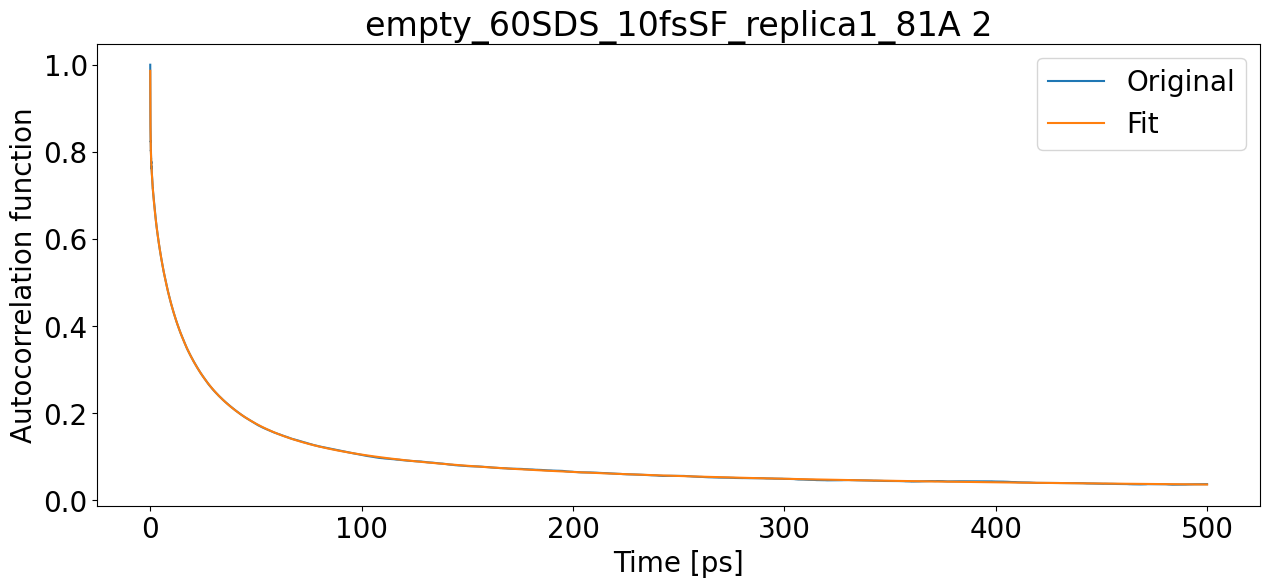

T1: 0.029316171152407547 T2: 0.02876140423163071 NOE: 0


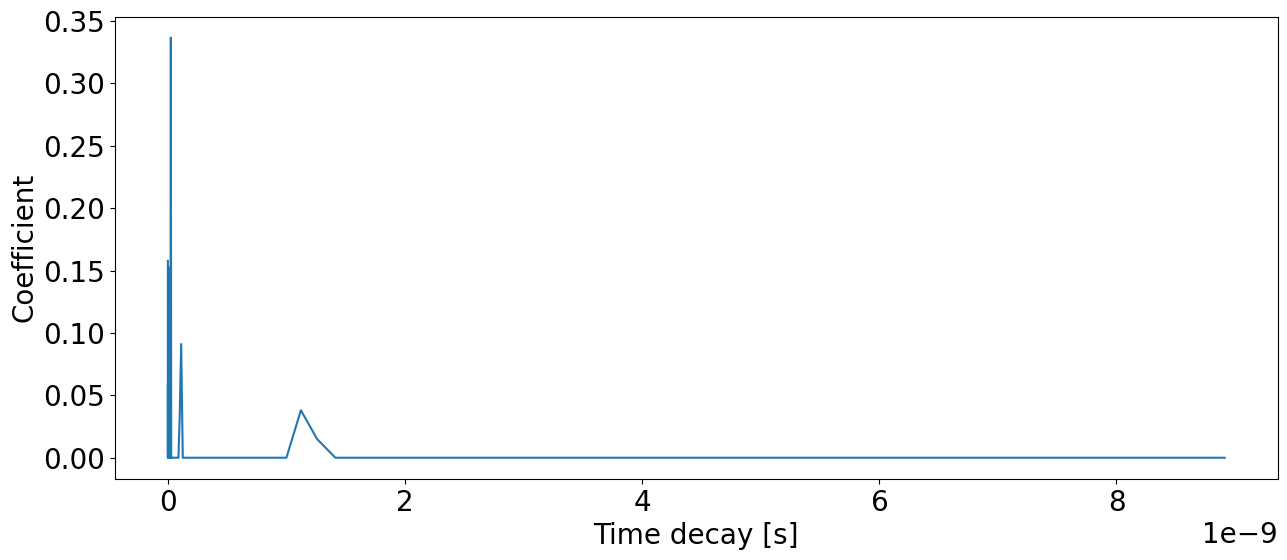

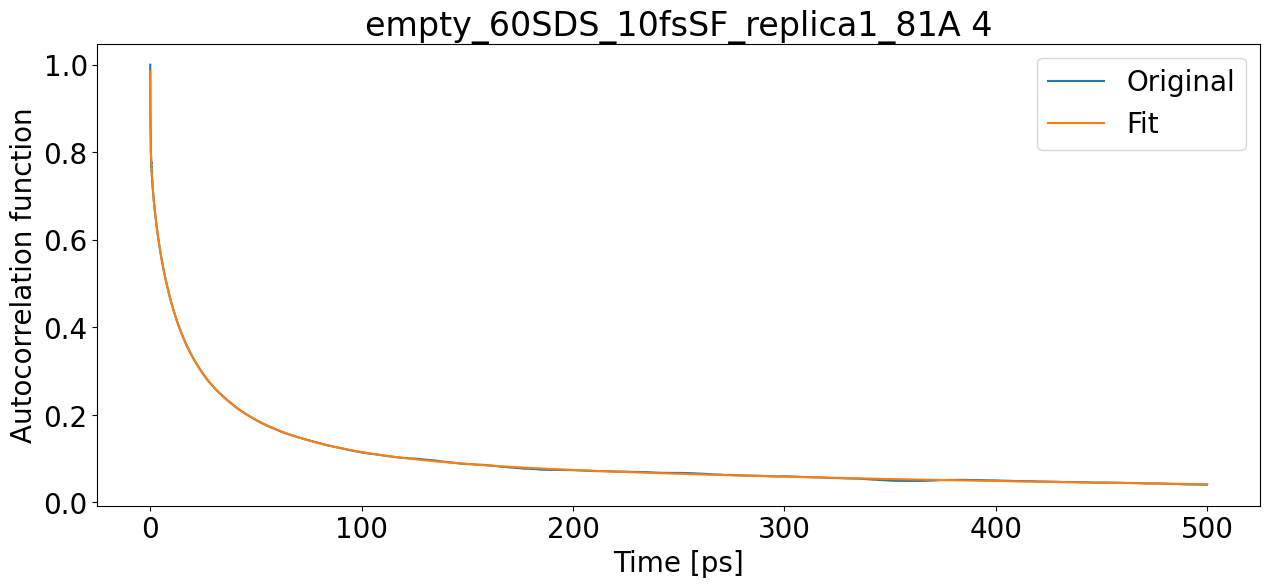

T1: 0.022644377378127693 T2: 0.014267742186502065 NOE: 0


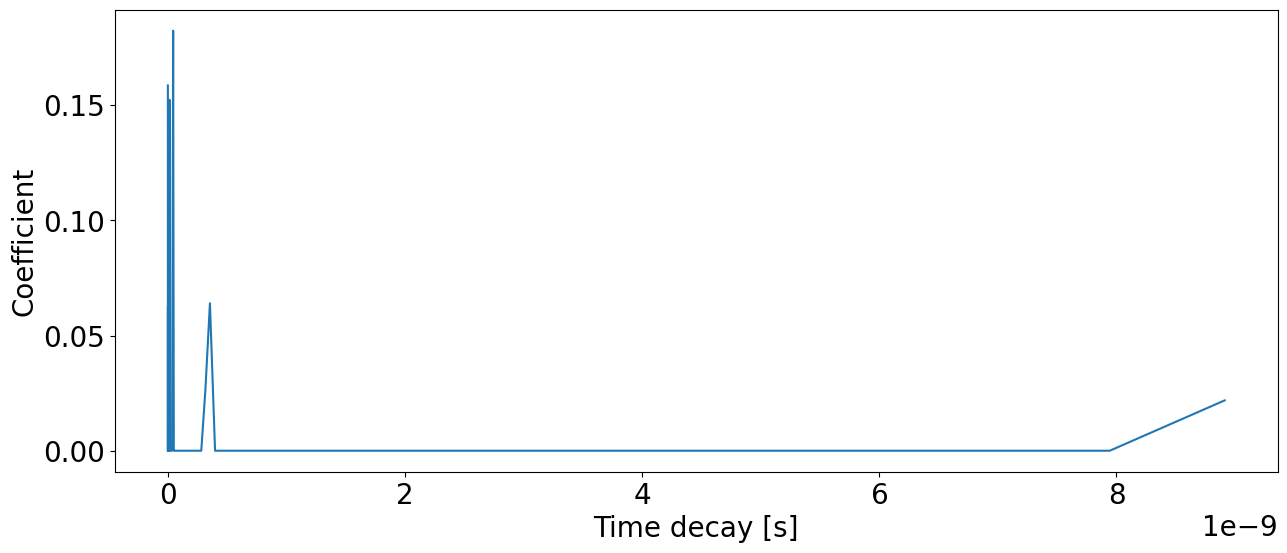

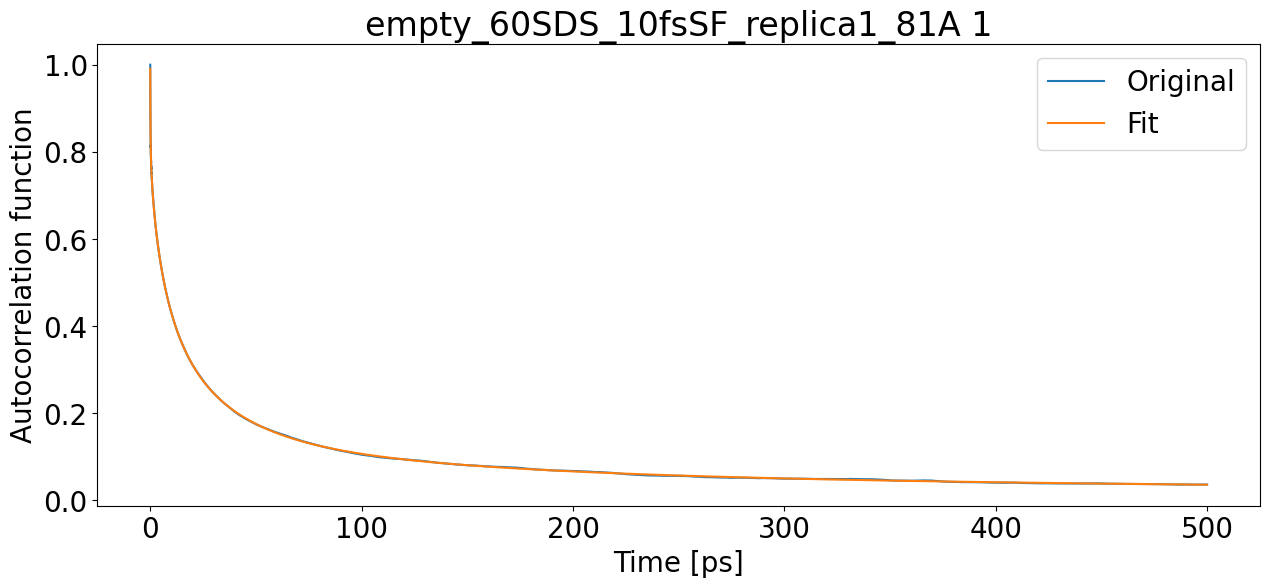

T1: 0.0316467529717225 T2: 0.031237944799831135 NOE: 0


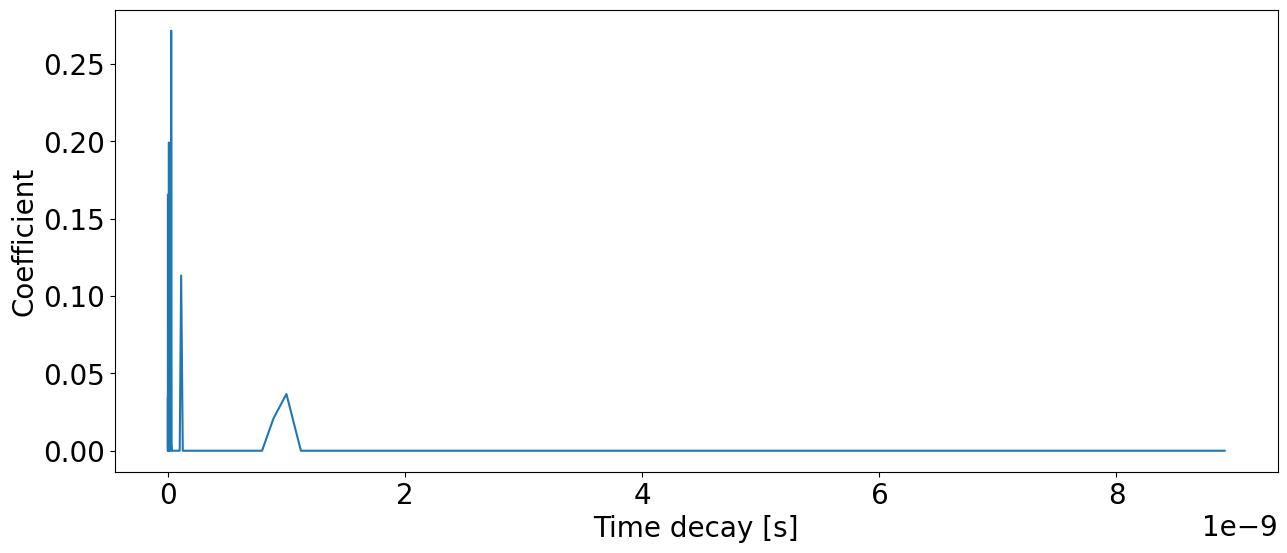

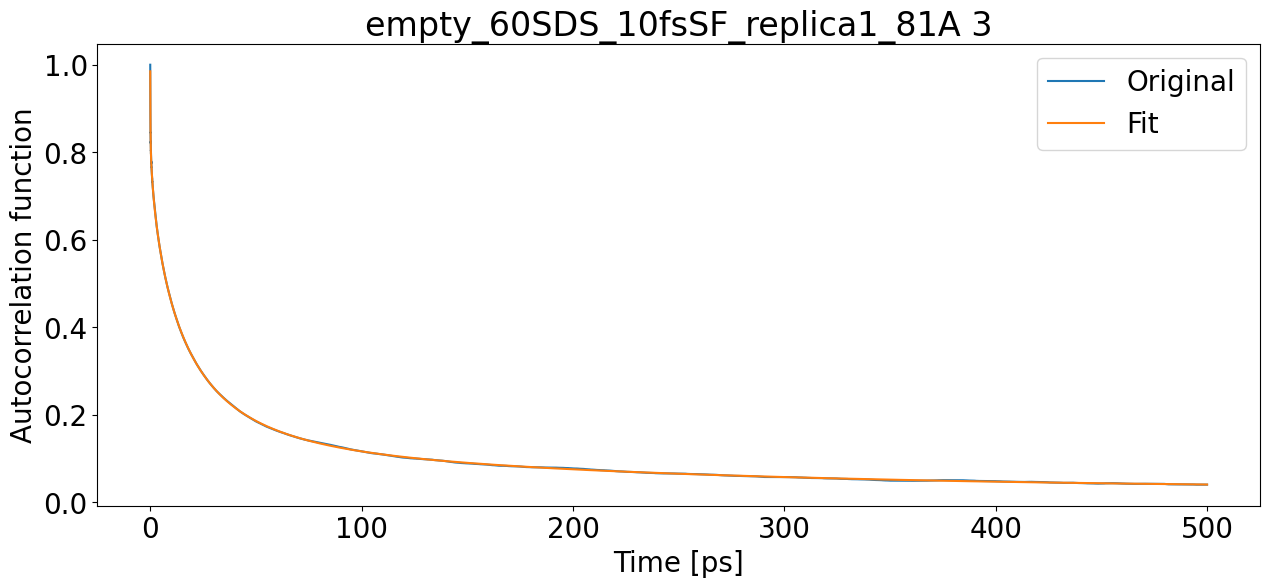

T1: 0.019166515803788073 T2: 0.010990477153984626 NOE: 0


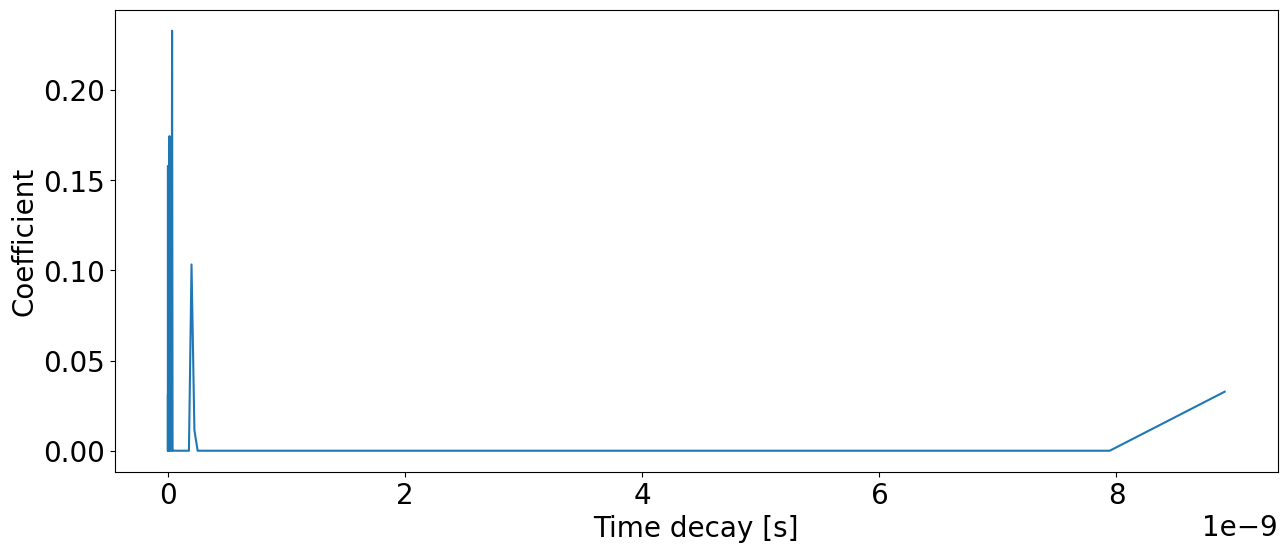

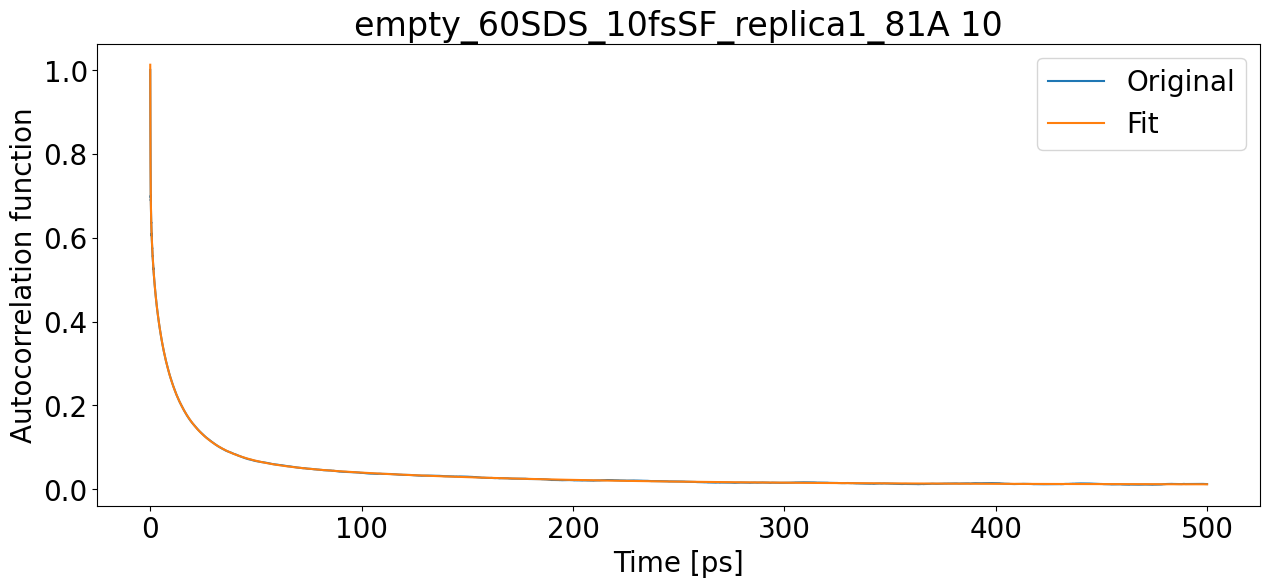

T1: 0.05158298733842054 T2: 0.029599999163257527 NOE: 0


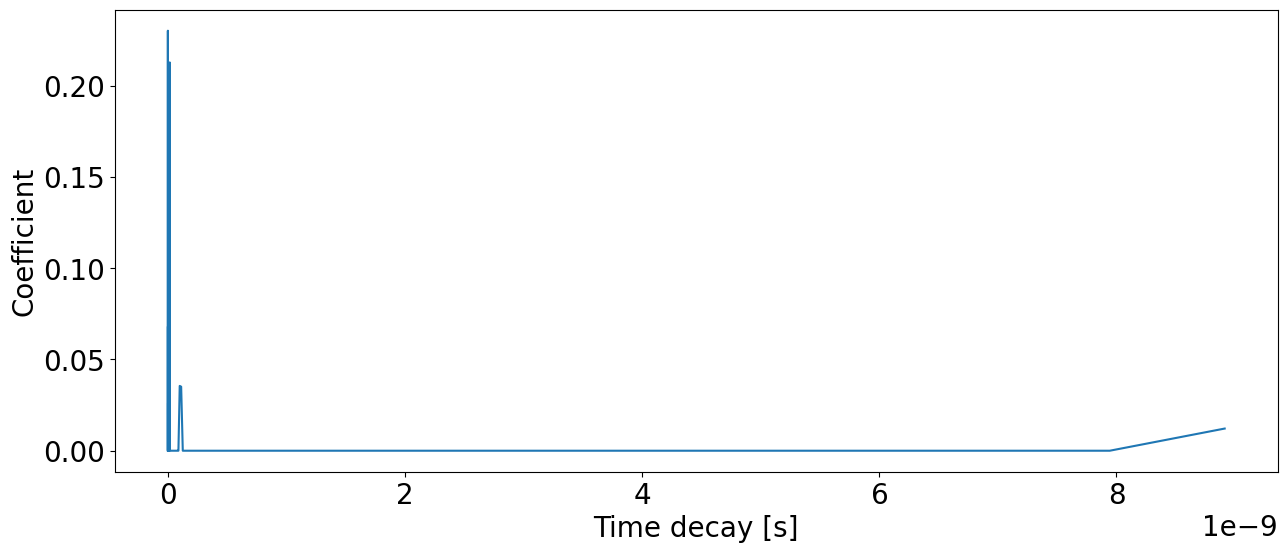

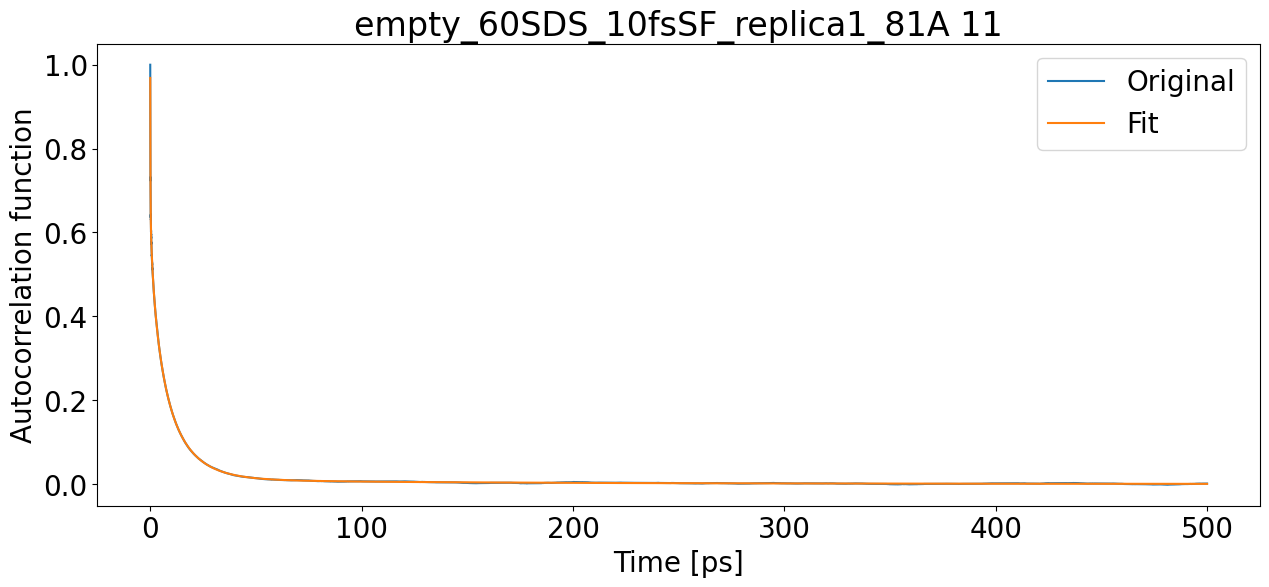

T1: 0.36091048365263784 T2: 0.36087200438301453 NOE: 0


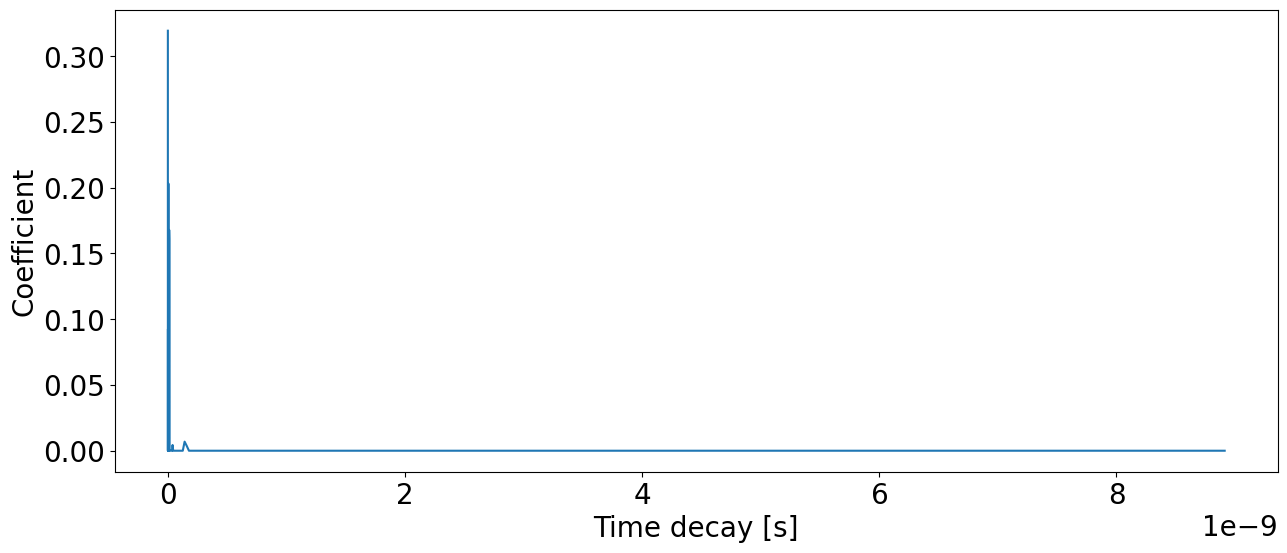

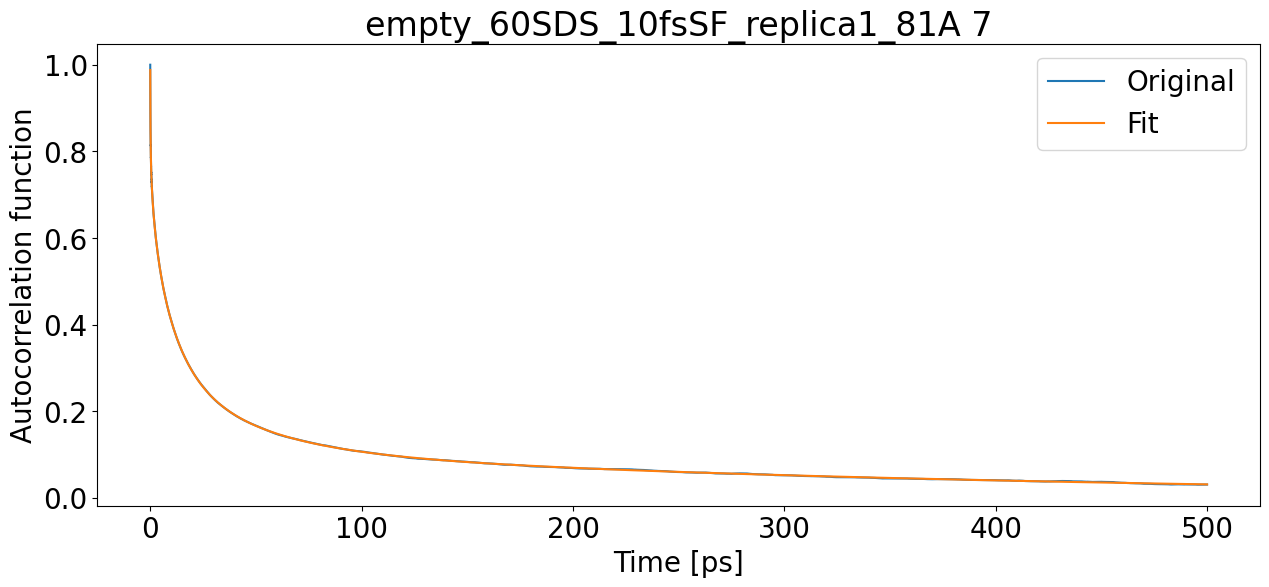

T1: 0.04304995229588783 T2: 0.04294893886217019 NOE: 0


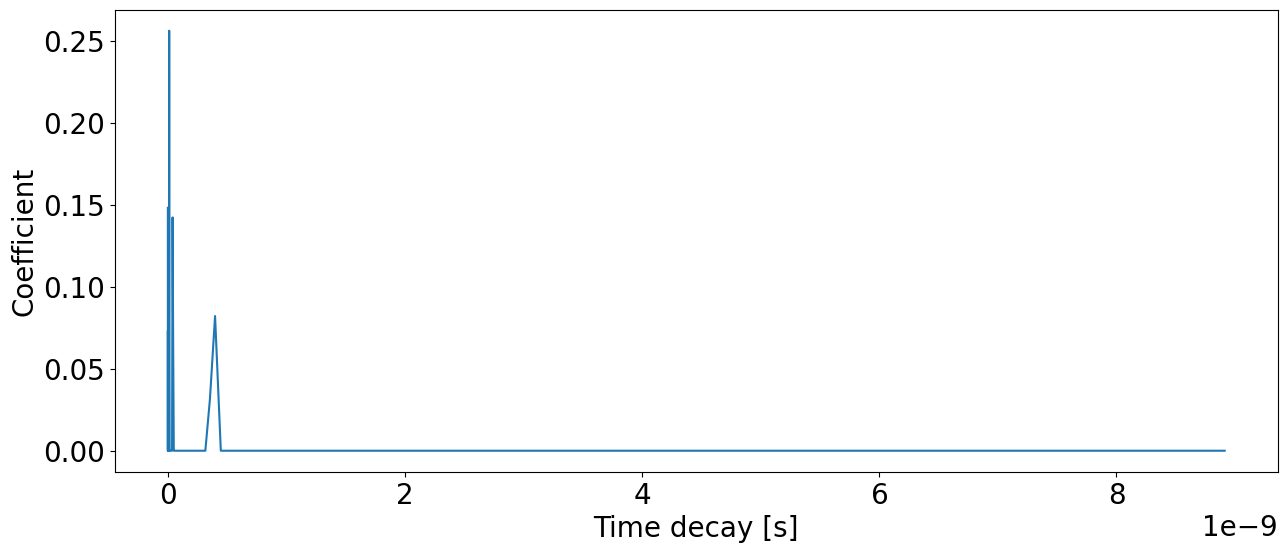

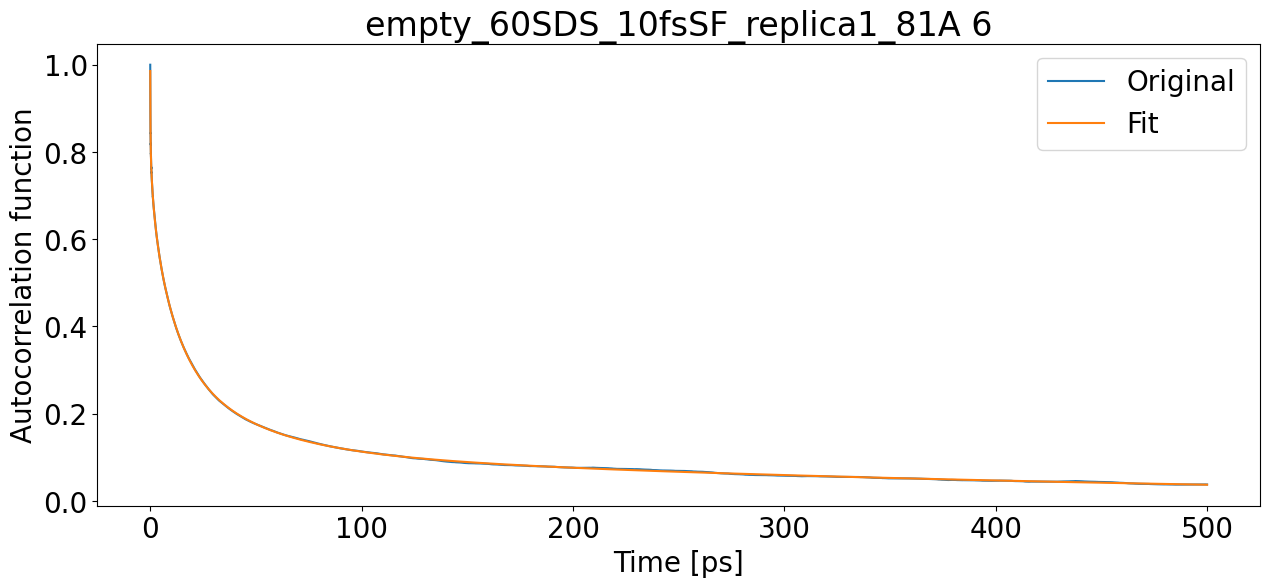

T1: 0.037707770936785644 T2: 0.03759456012296765 NOE: 0


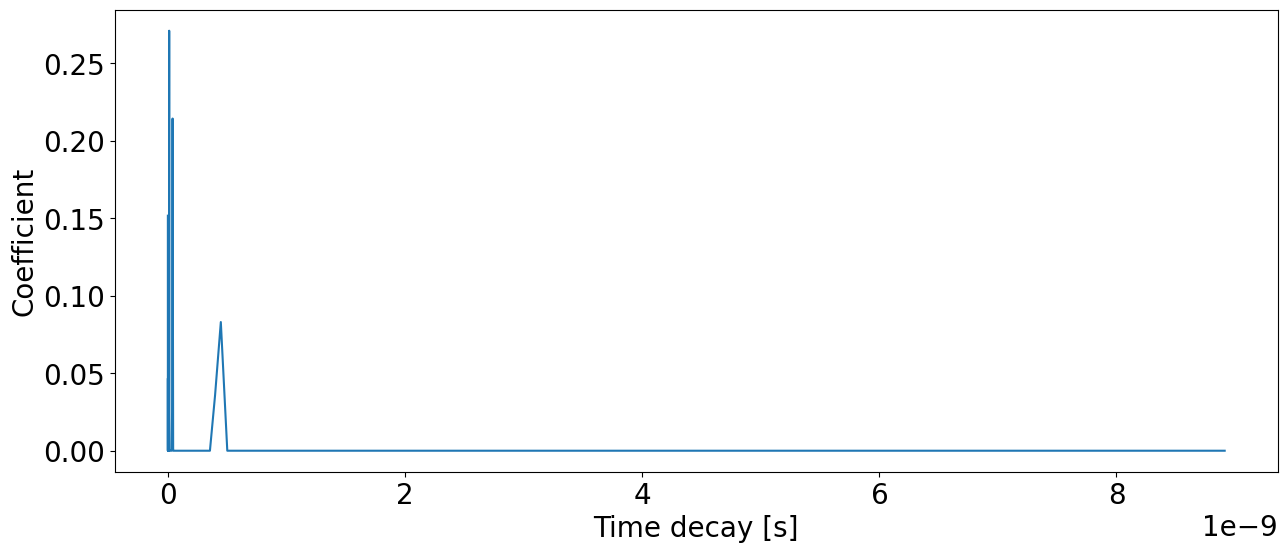

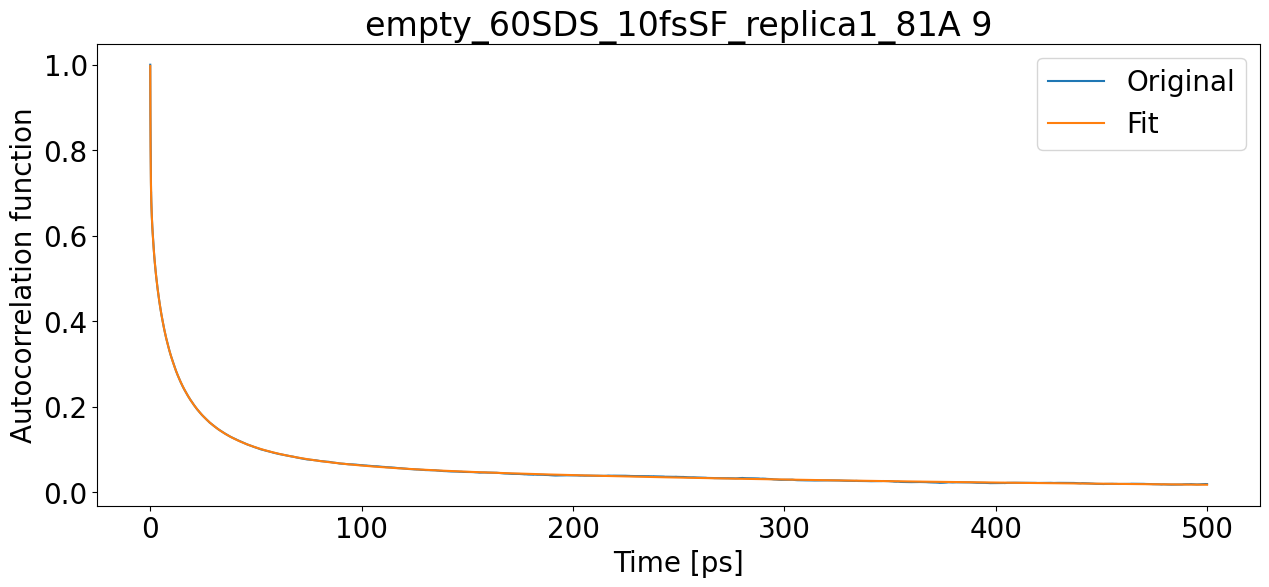

T1: 0.05691982685523885 T2: 0.04310040881933638 NOE: 0


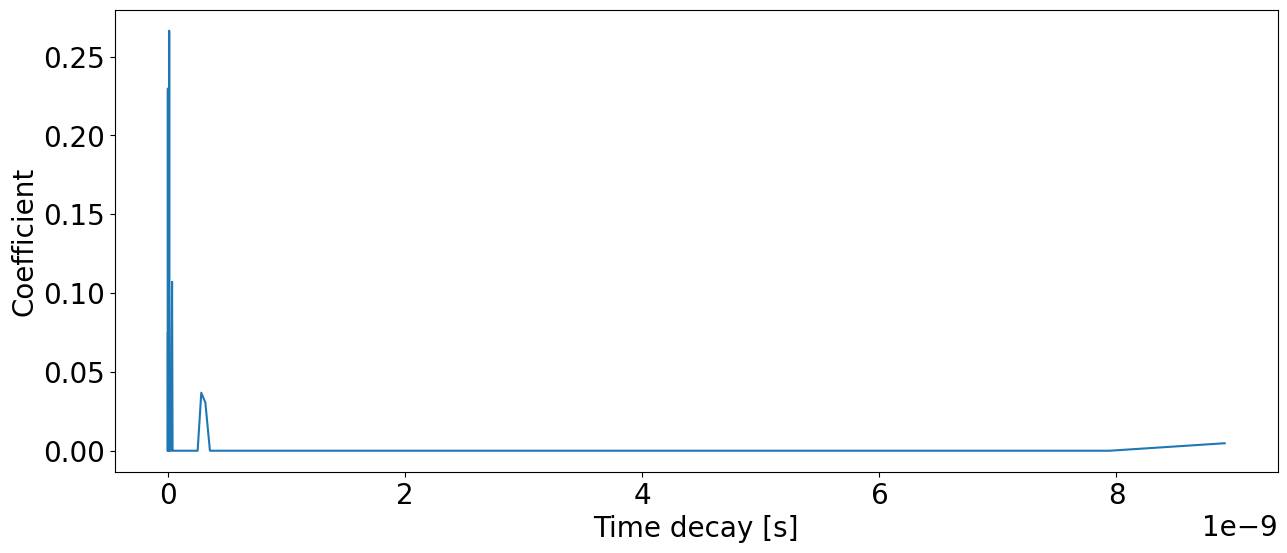

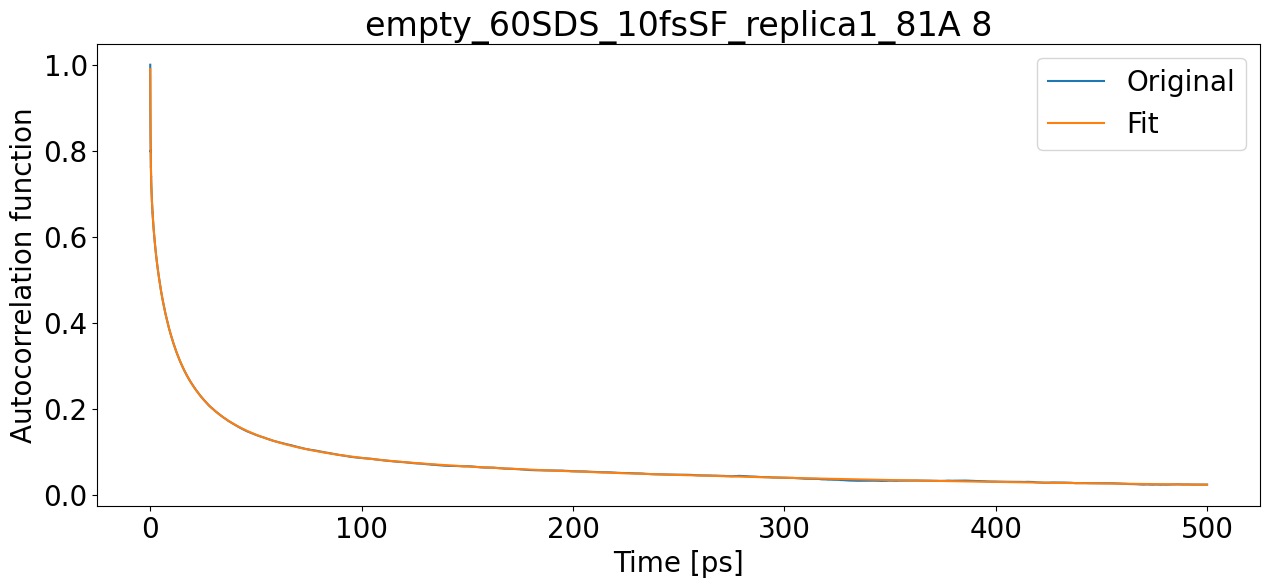

T1: 0.03859506899823278 T2: 0.02631637843730013 NOE: 0


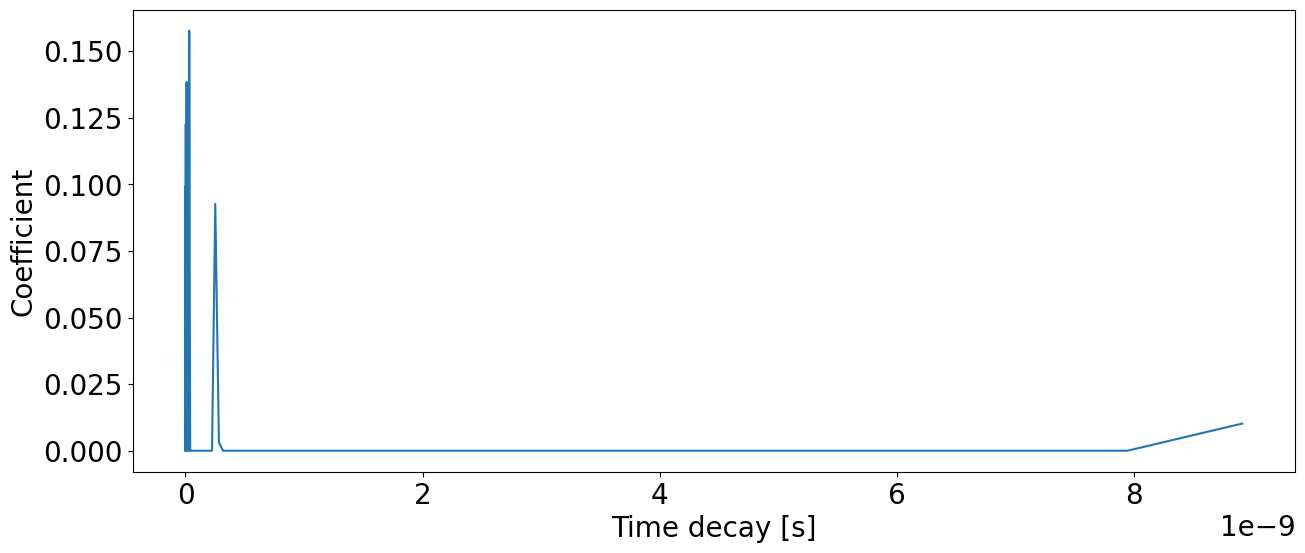

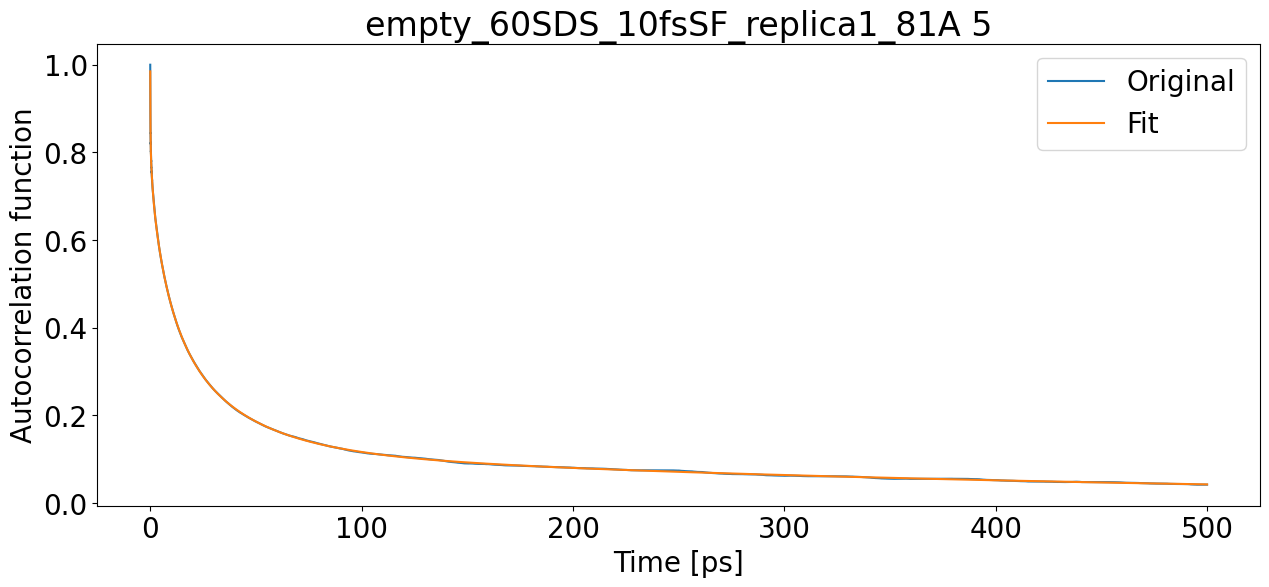

T1: 0.027548411963500392 T2: 0.02057135122521151 NOE: 0


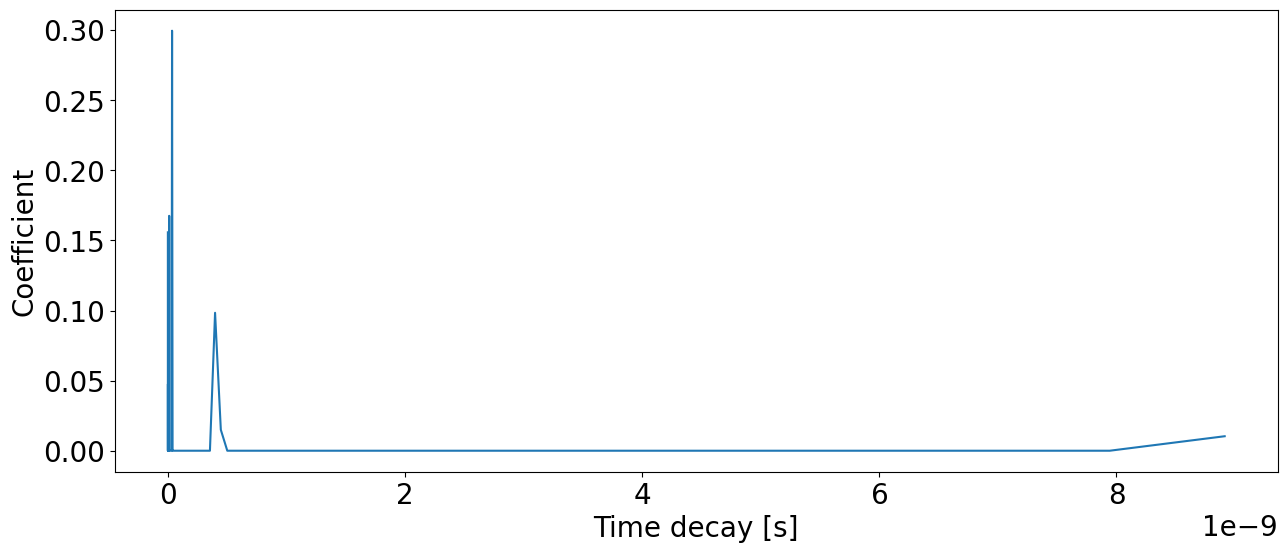

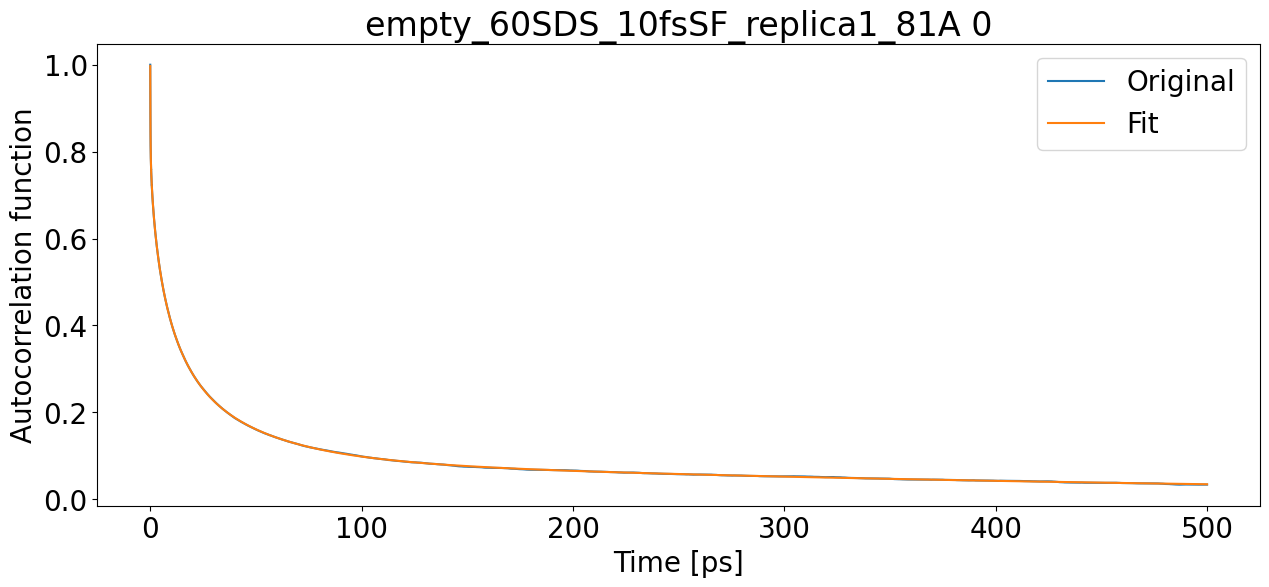

T1: 0.040494655544940354 T2: 0.04034426442395728 NOE: 0


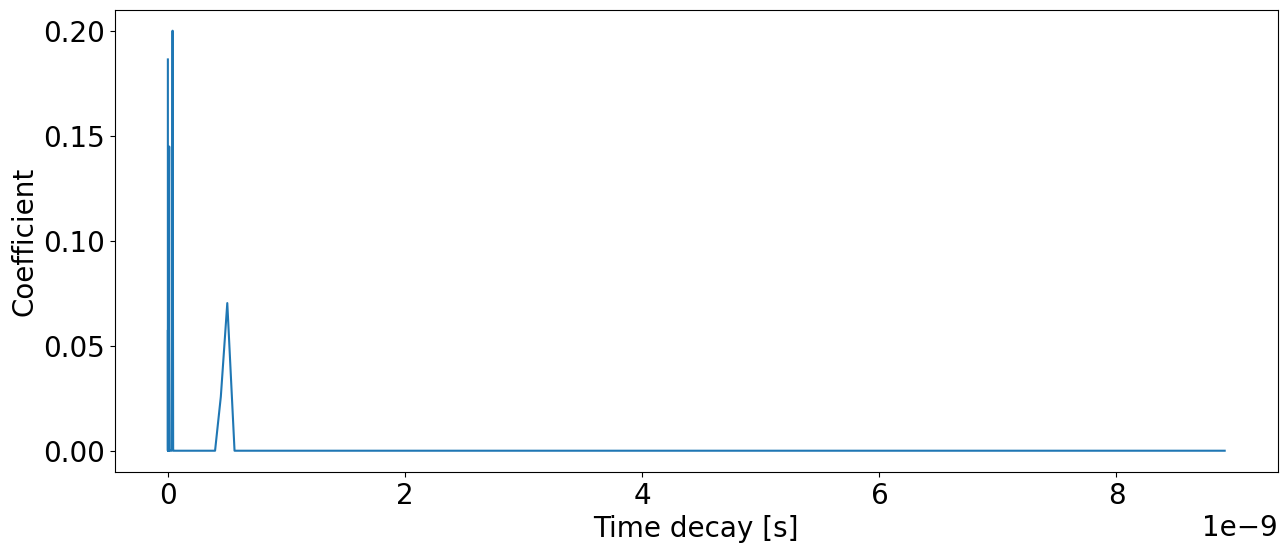

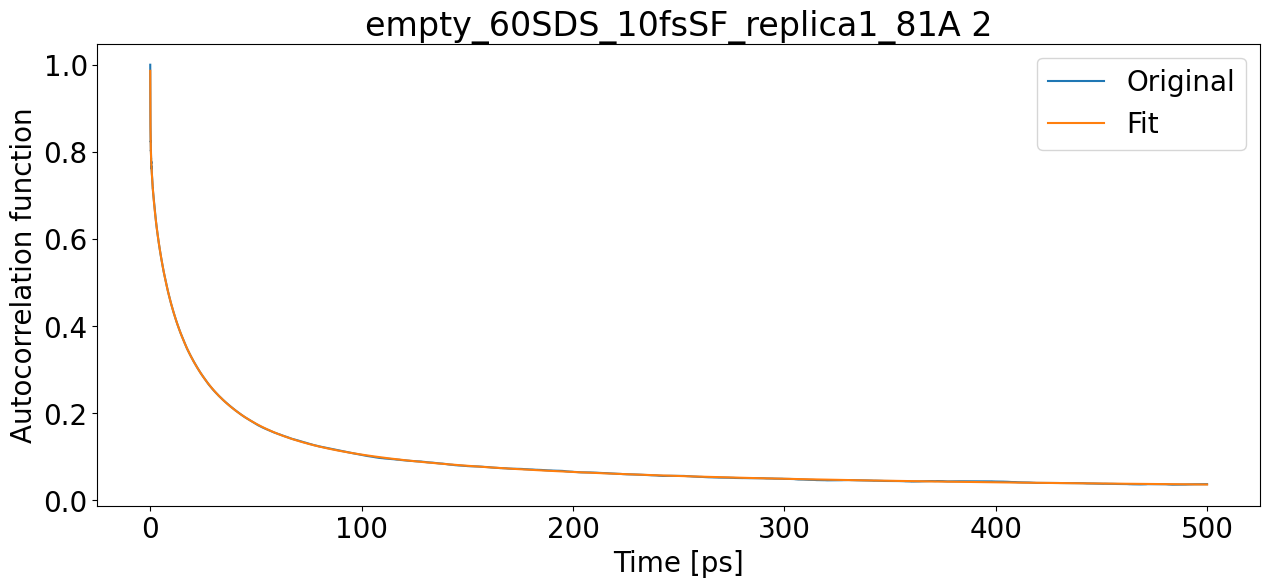

T1: 0.03373146383363386 T2: 0.030389037512567576 NOE: 0


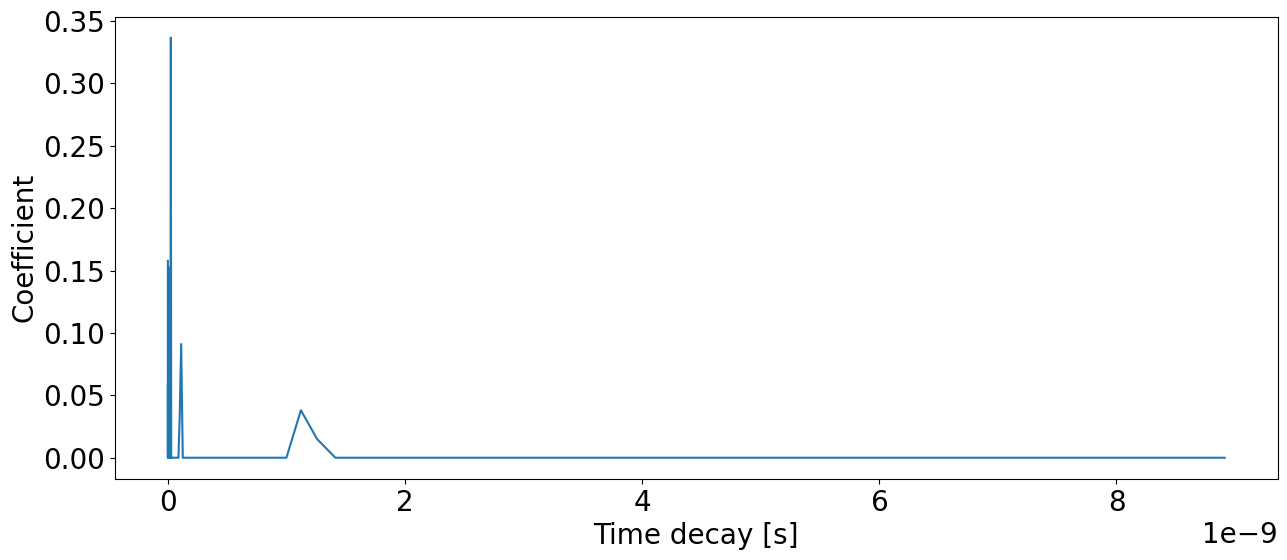

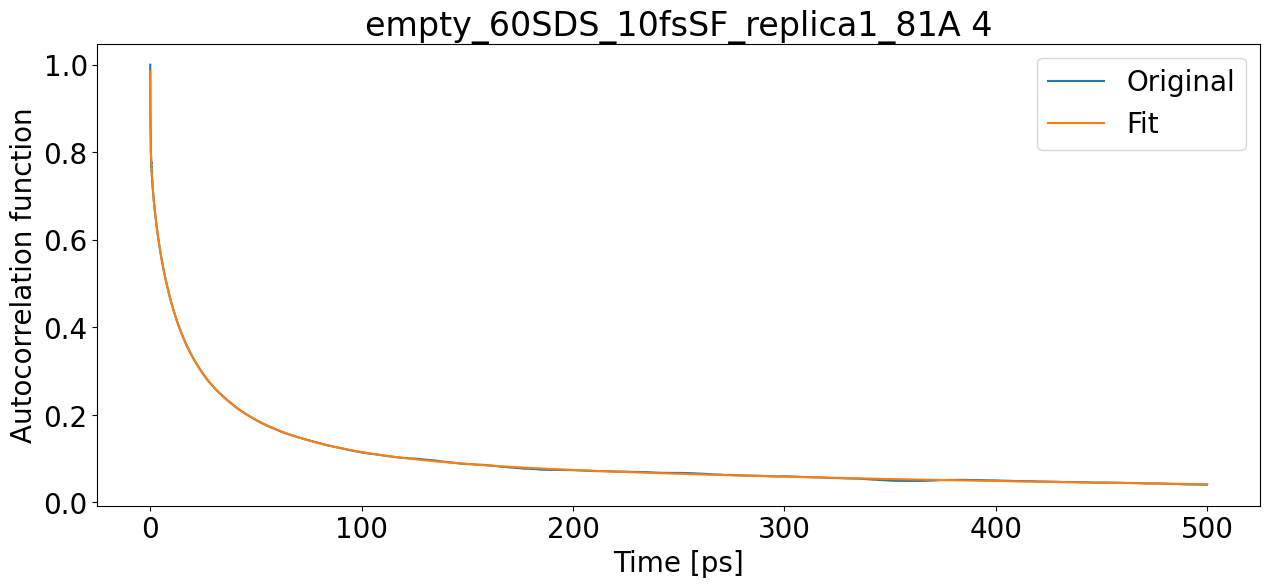

T1: 0.04051729324644765 T2: 0.01971203397633661 NOE: 0


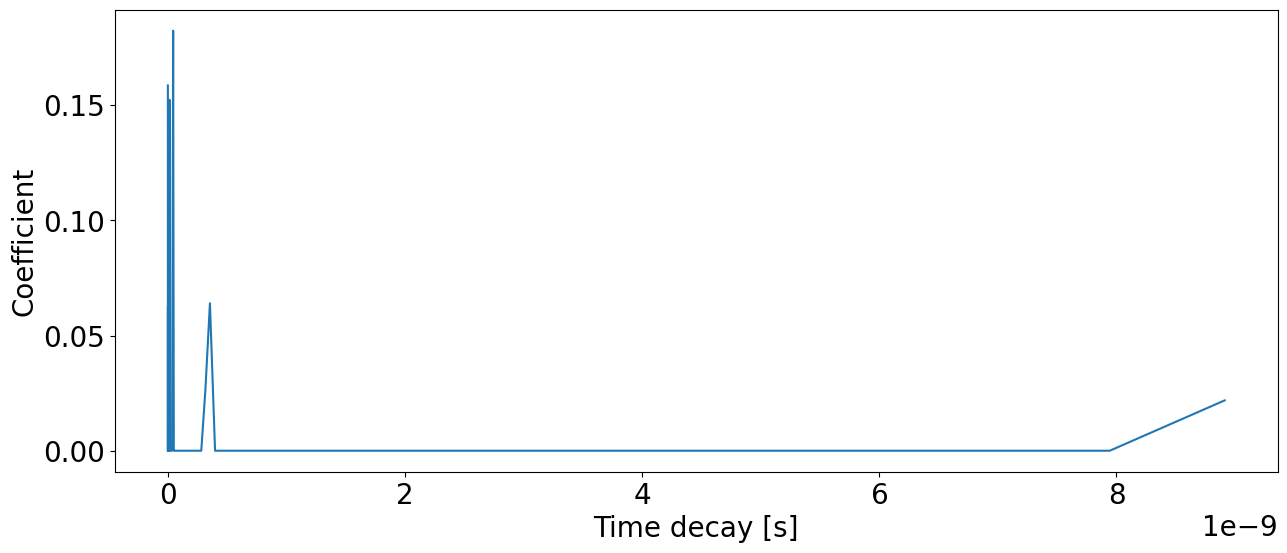

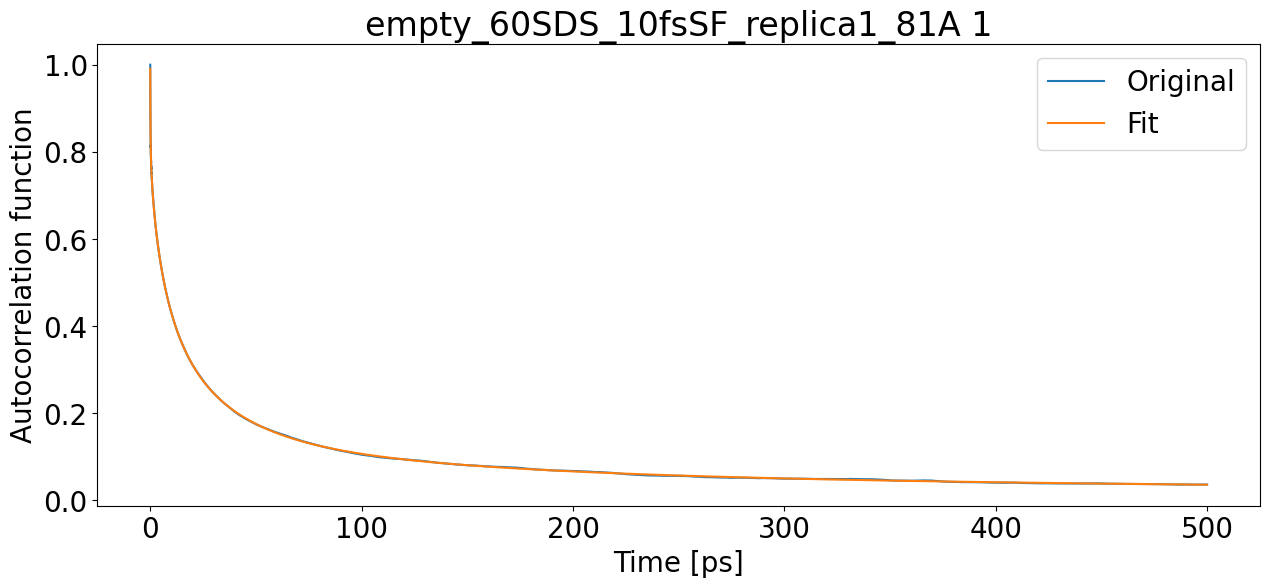

T1: 0.03500368762080105 T2: 0.03248820189005205 NOE: 0


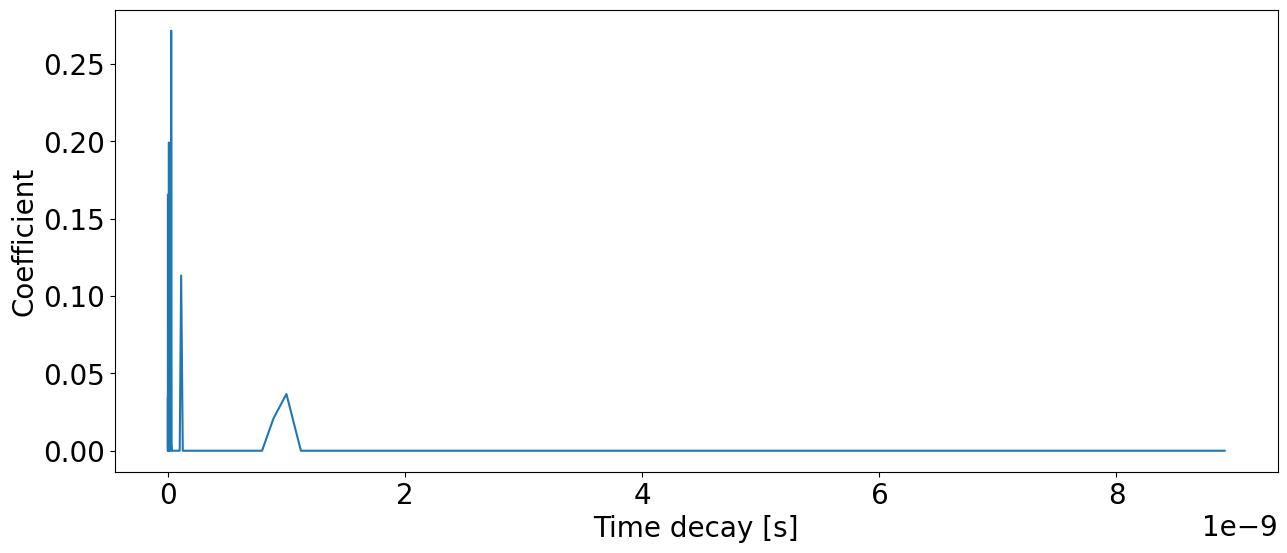

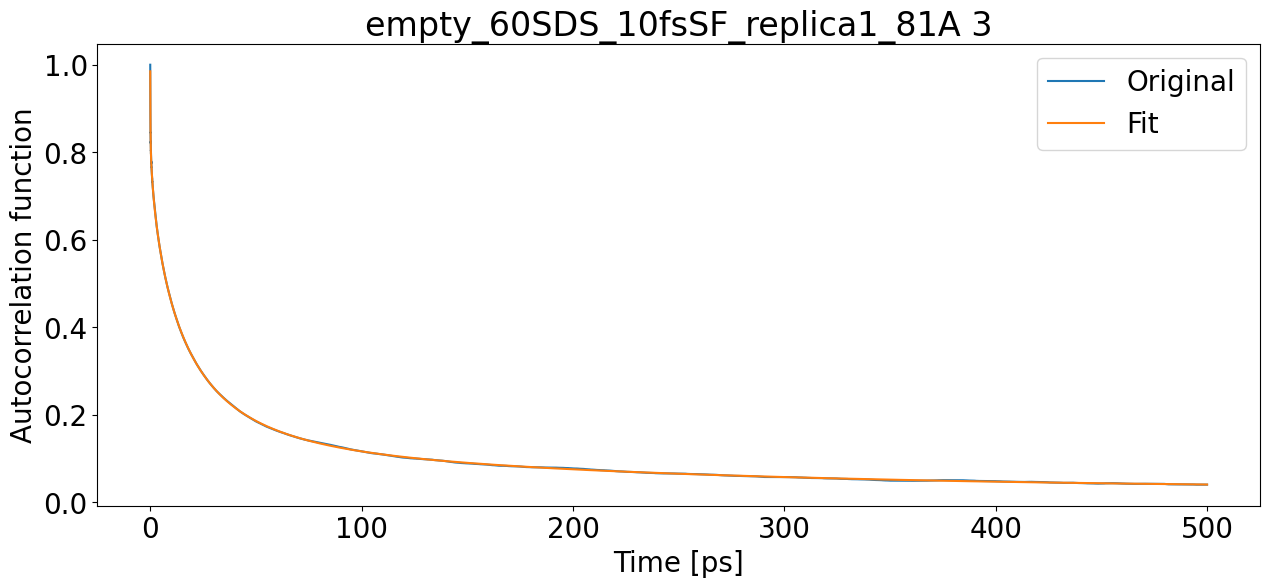

T1: 0.04289675821180151 T2: 0.016101193663963658 NOE: 0


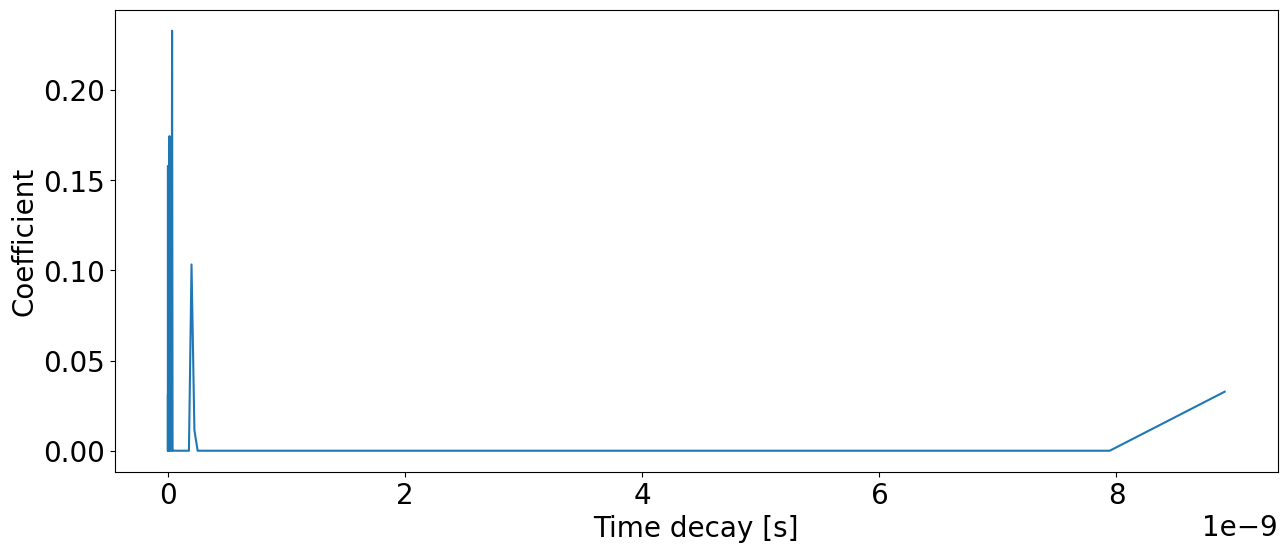

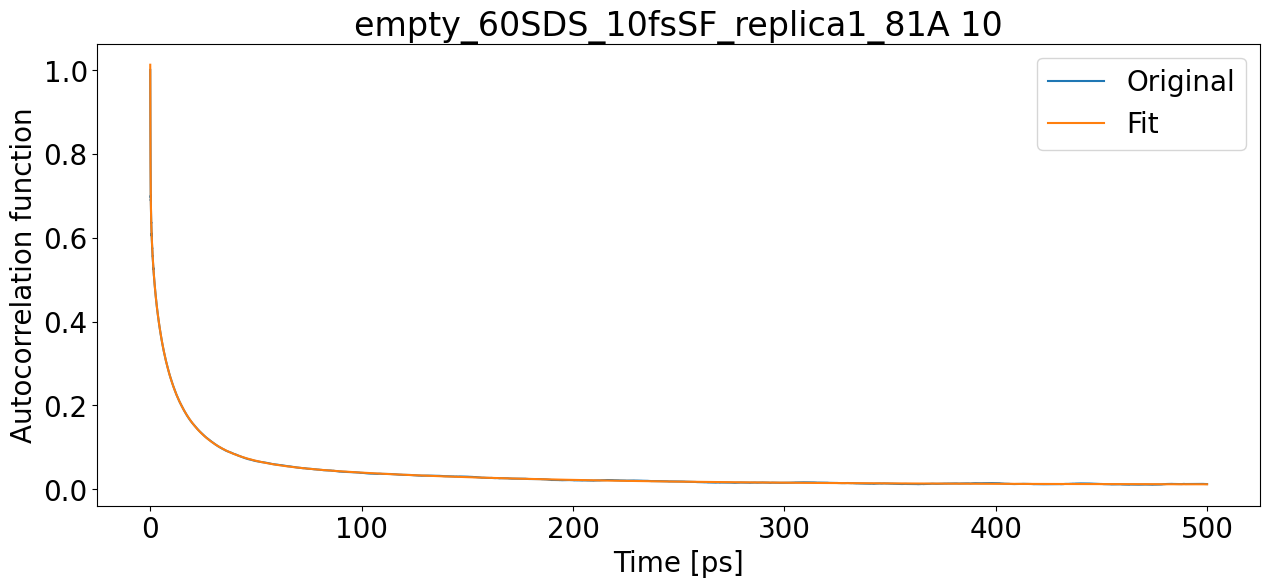

T1: 0.11496940612955373 T2: 0.04333385544795096 NOE: 0


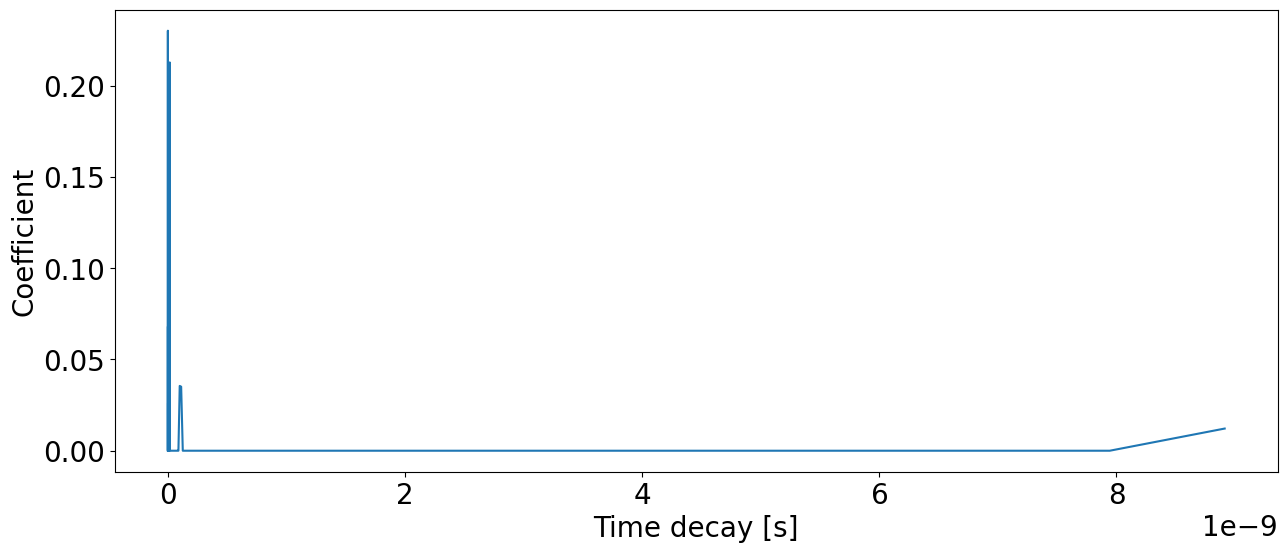

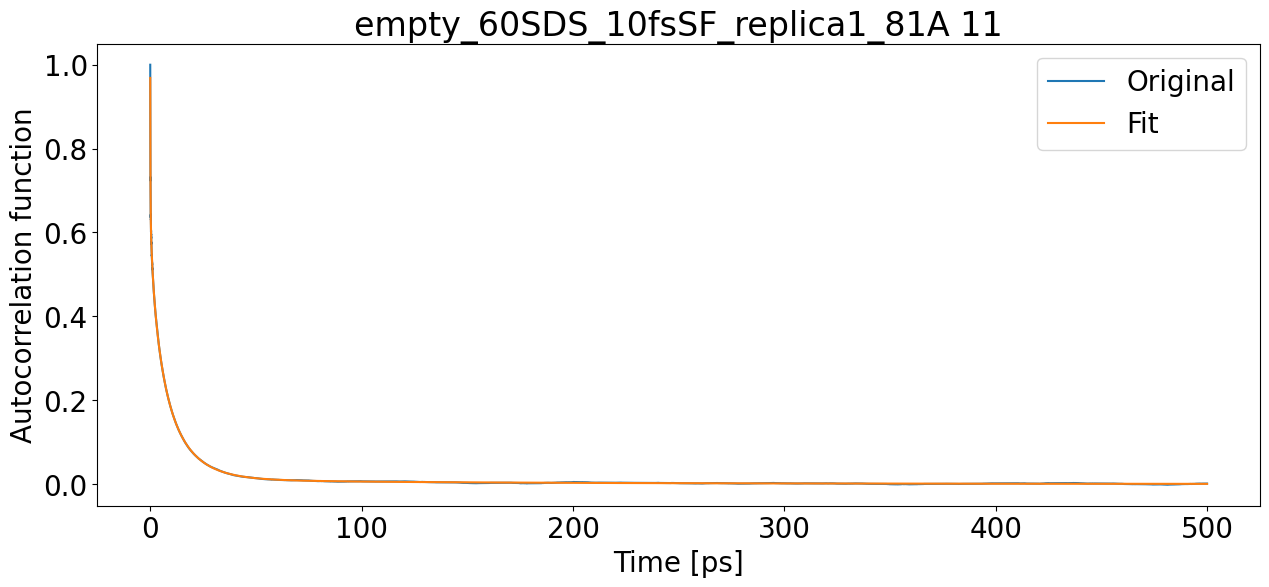

T1: 0.36125158886427944 T2: 0.36100252187077714 NOE: 0


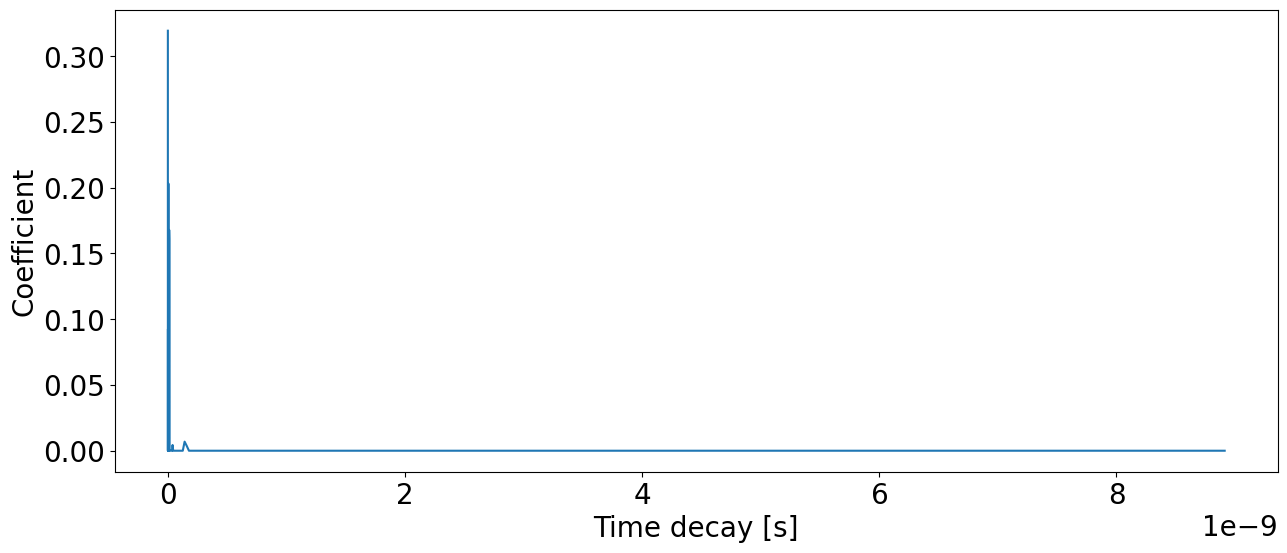

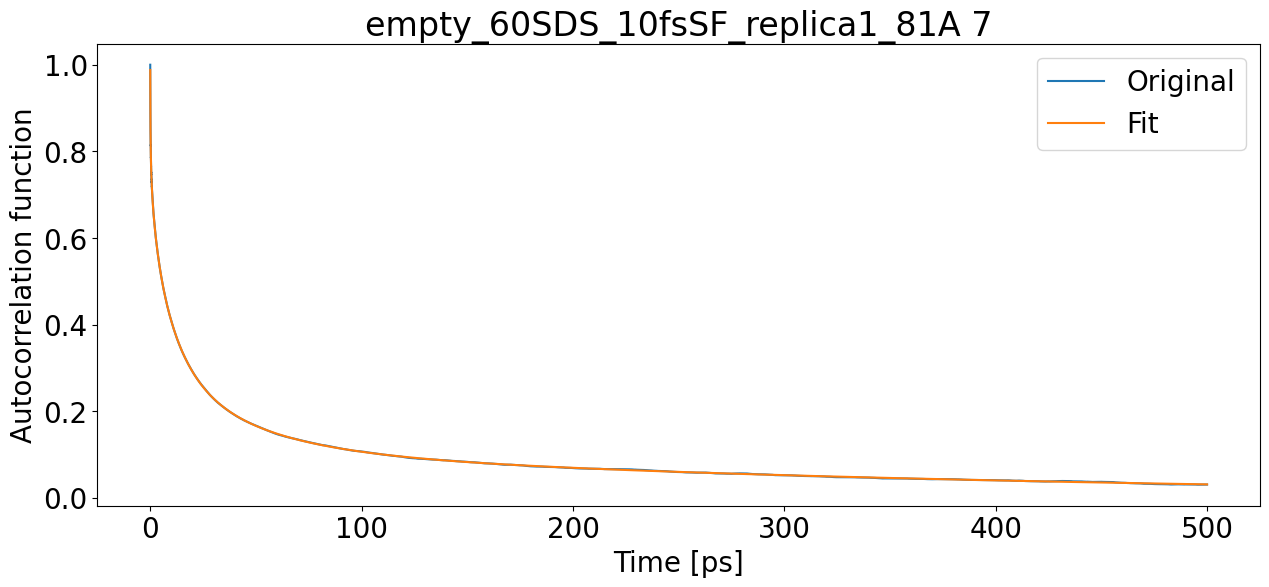

T1: 0.043938516348665434 T2: 0.043286382814925604 NOE: 0


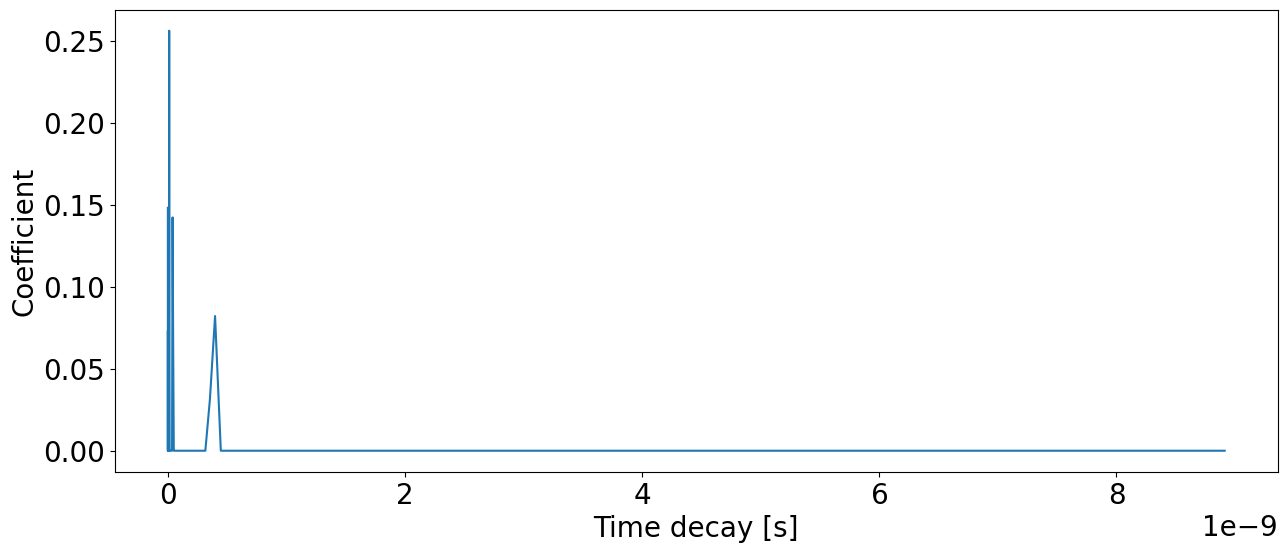

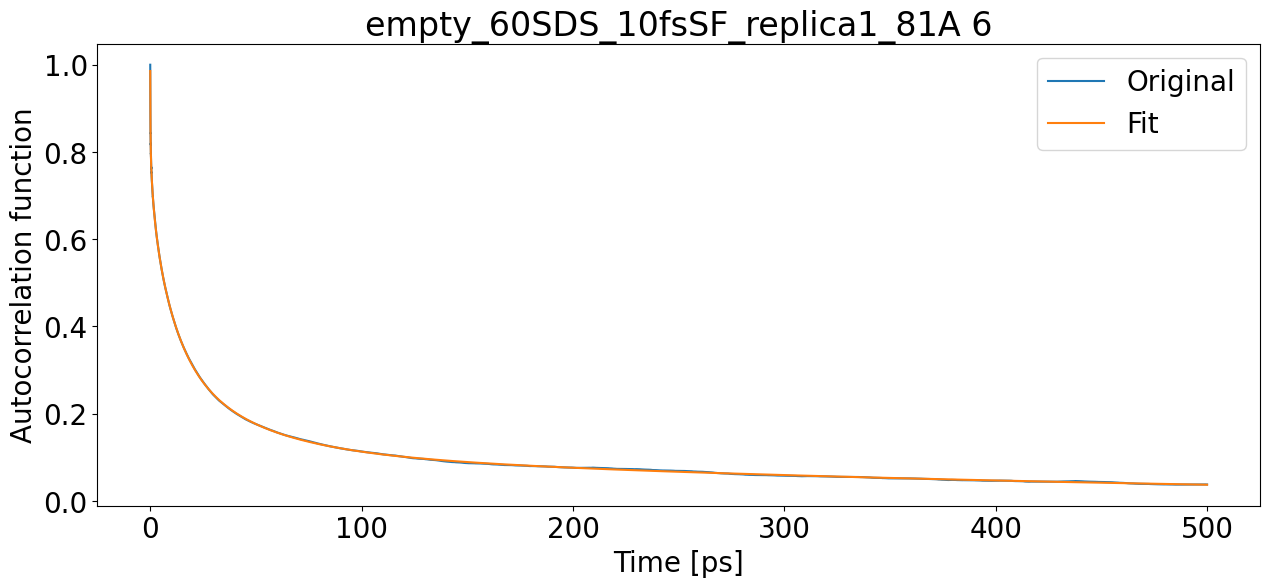

T1: 0.038701318844919515 T2: 0.03797107376211667 NOE: 0


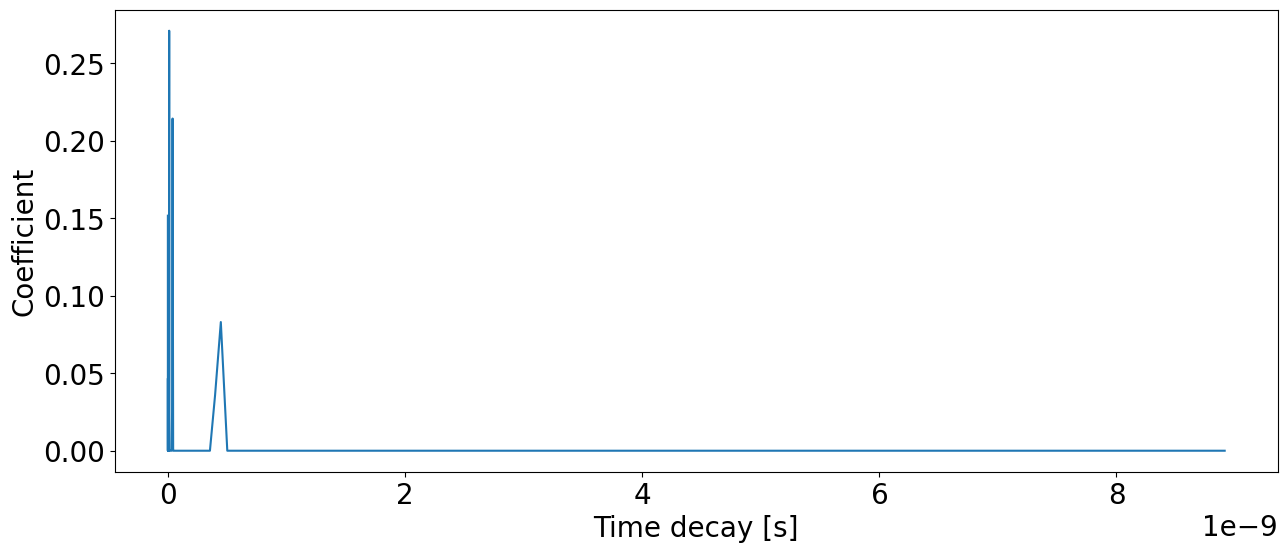

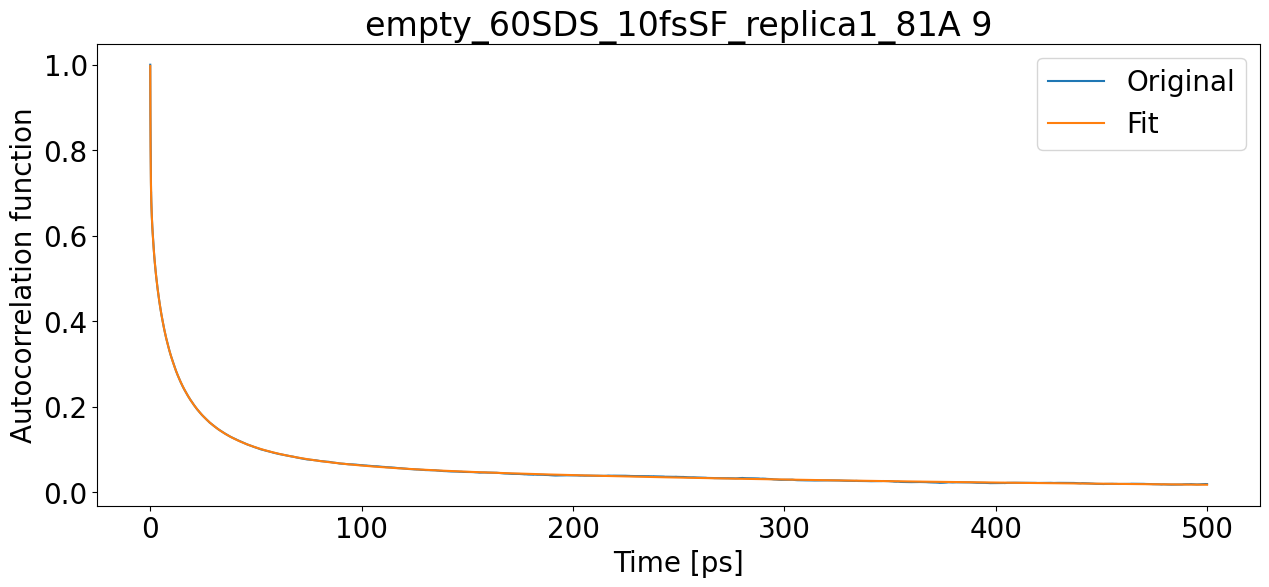

T1: 0.0753567146796958 T2: 0.05270287717241328 NOE: 0


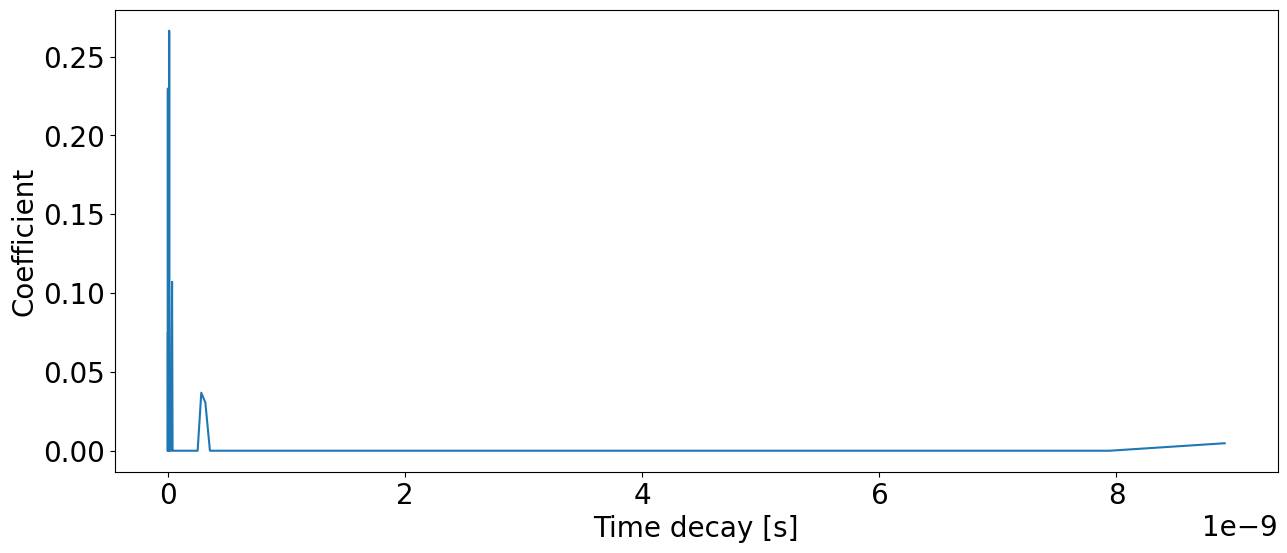

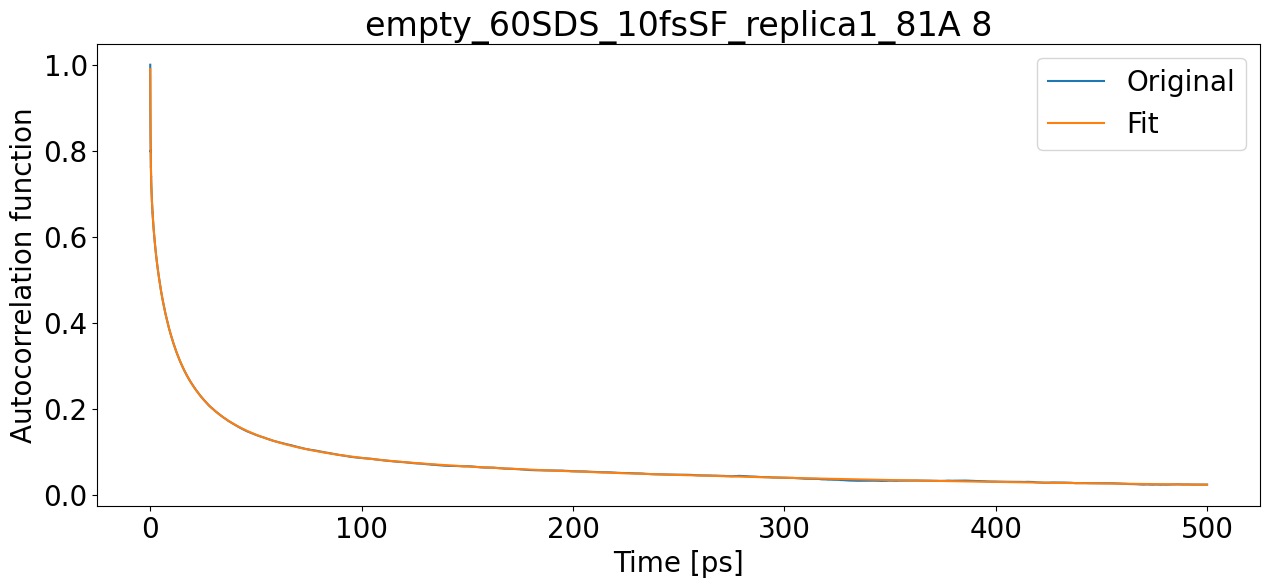

T1: 0.05939239359558455 T2: 0.03451060266191571 NOE: 0


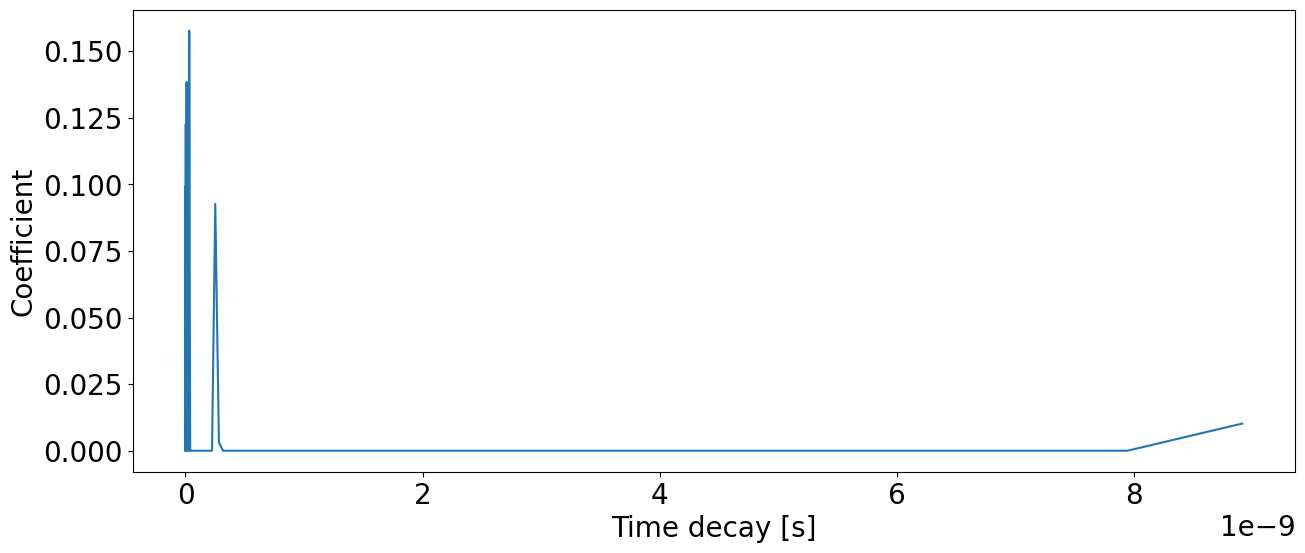

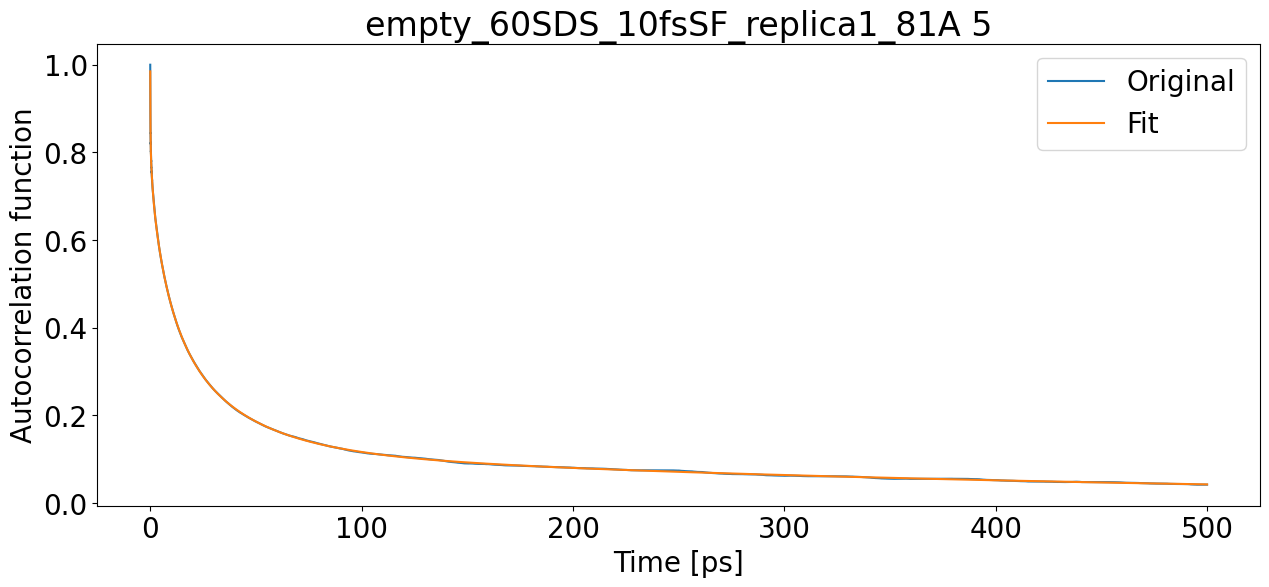

T1: 0.03748653411041804 T2: 0.02544752940225564 NOE: 0


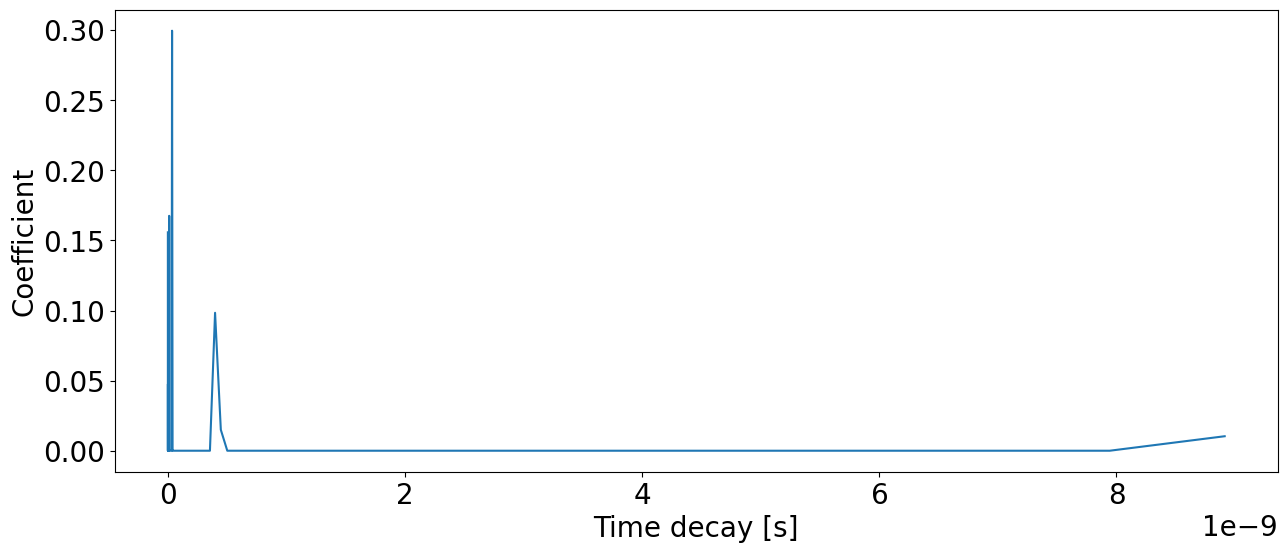

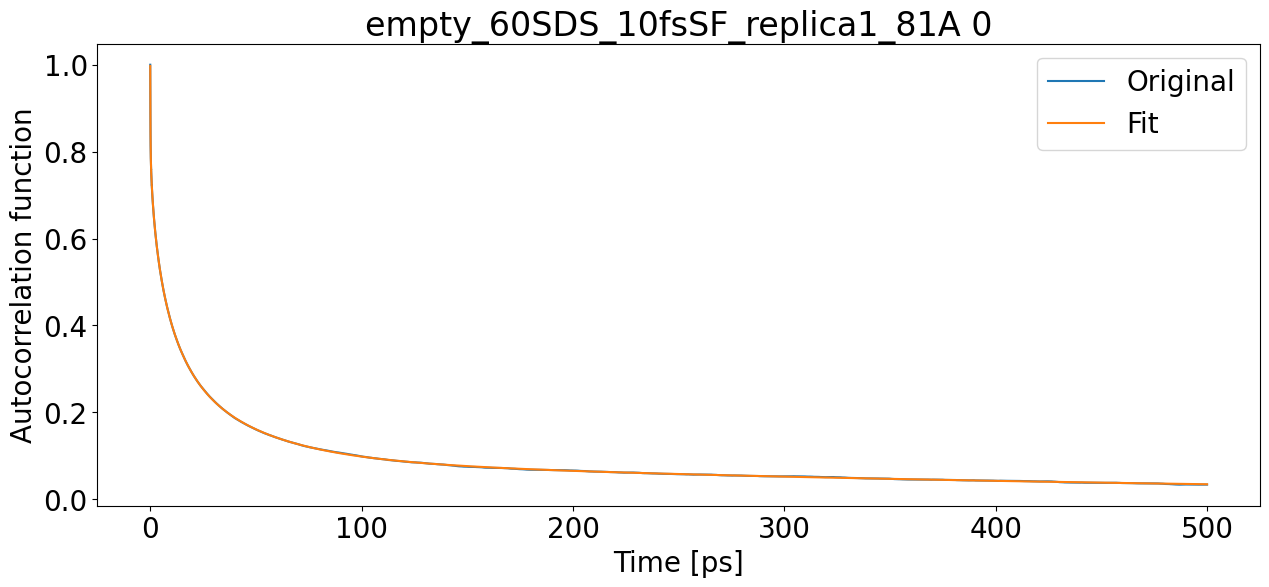

T1: 0.041808586814157264 T2: 0.04084137823185294 NOE: 0


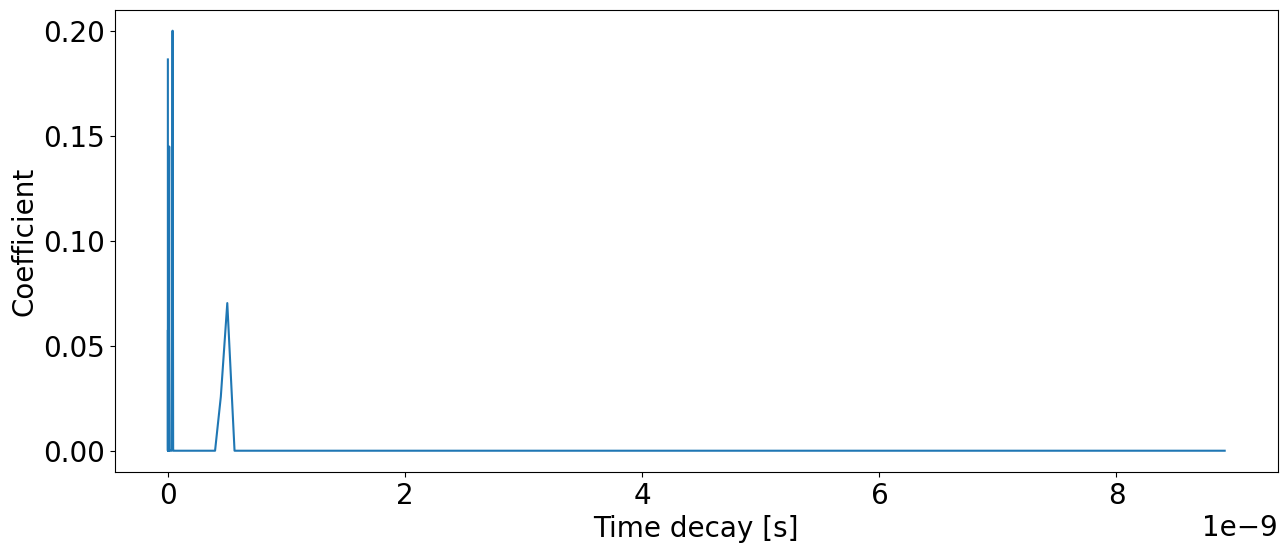

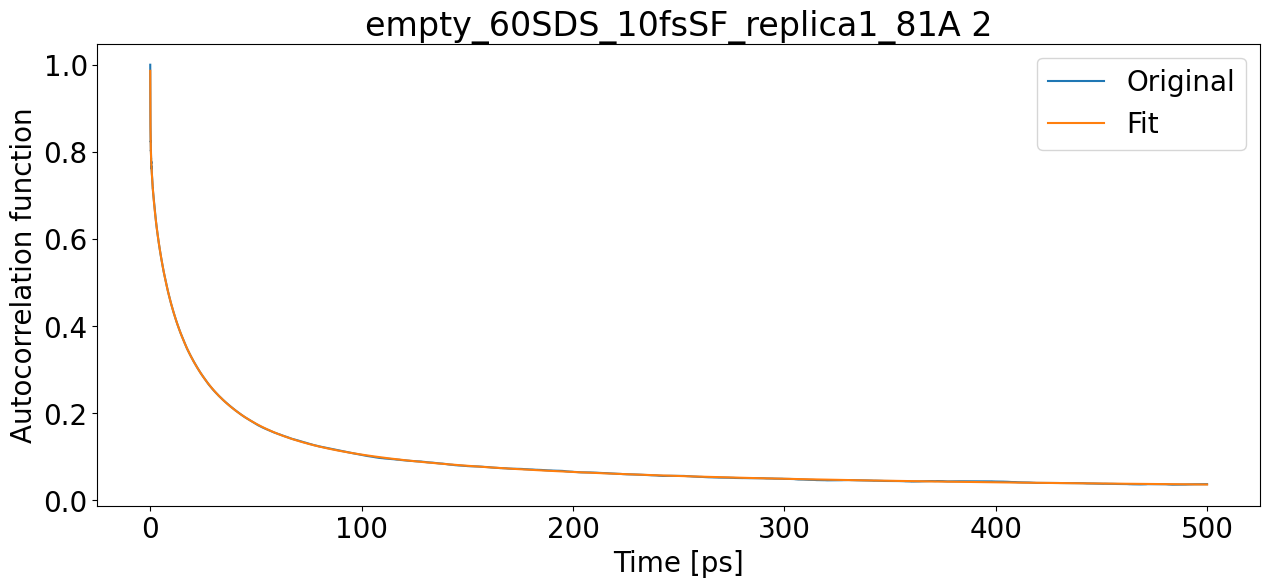

T1: 0.03814288220471316 T2: 0.0319692610817988 NOE: 0


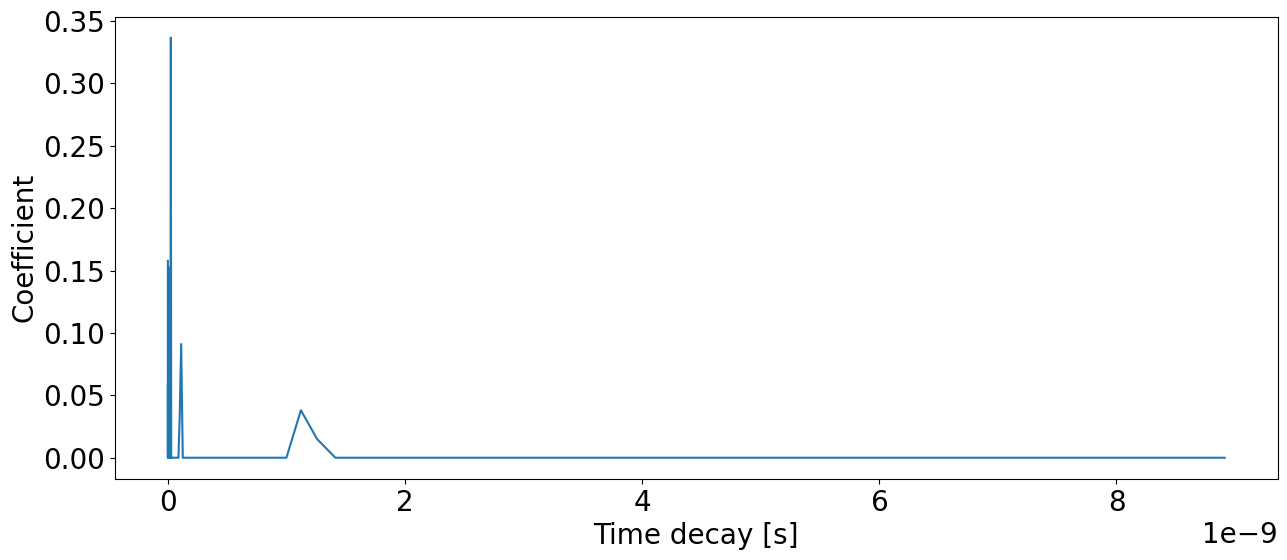

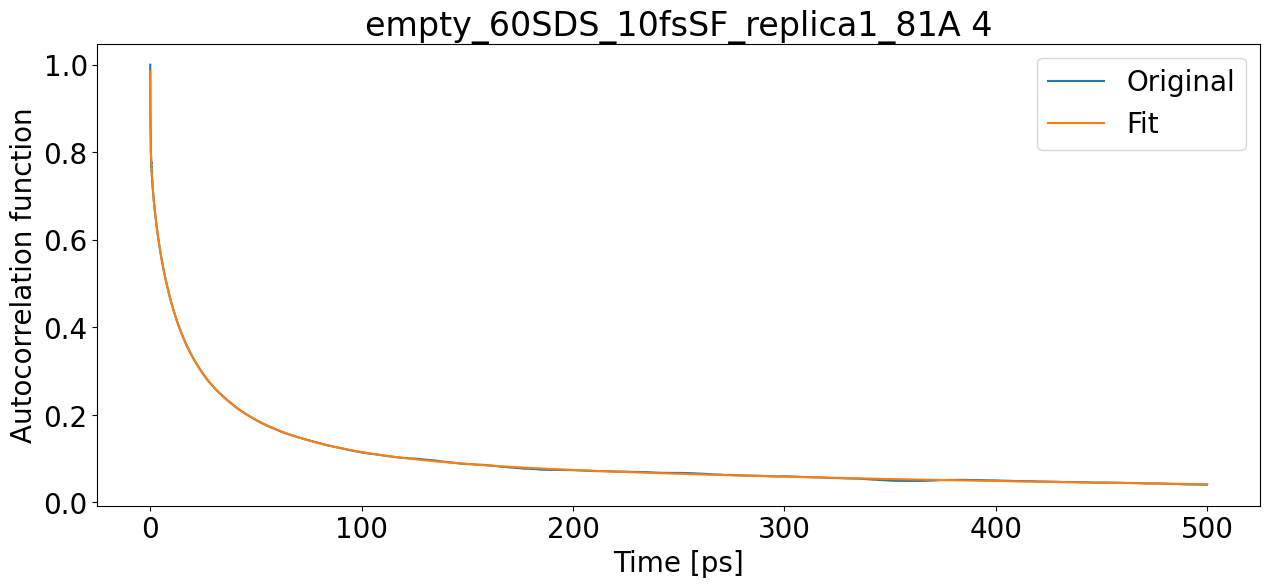

T1: 0.04622544061209171 T2: 0.02120753732231667 NOE: 0


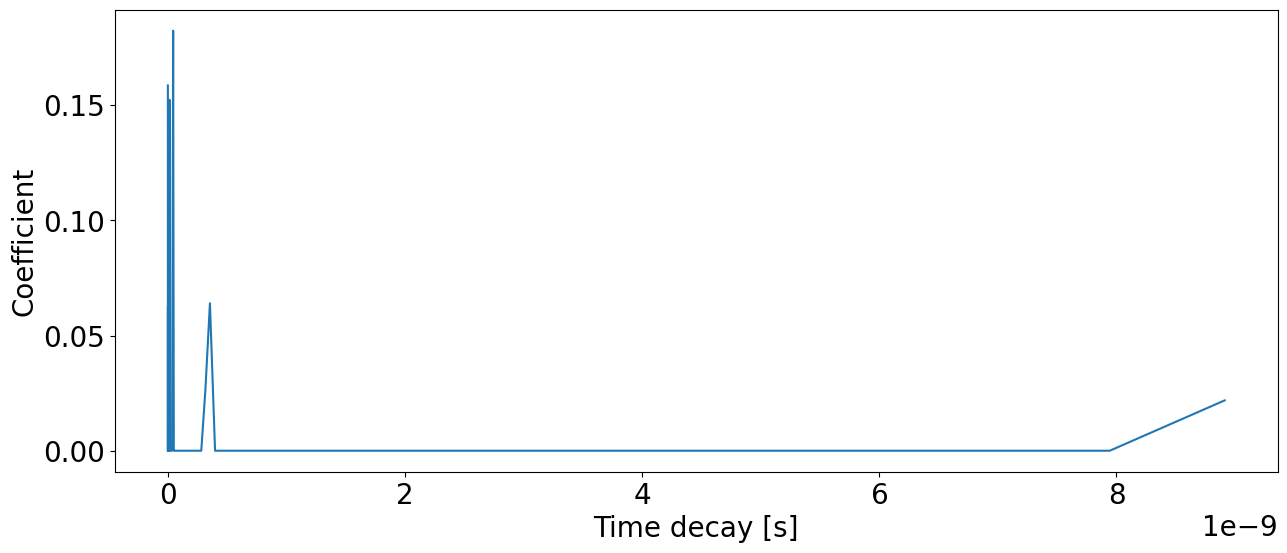

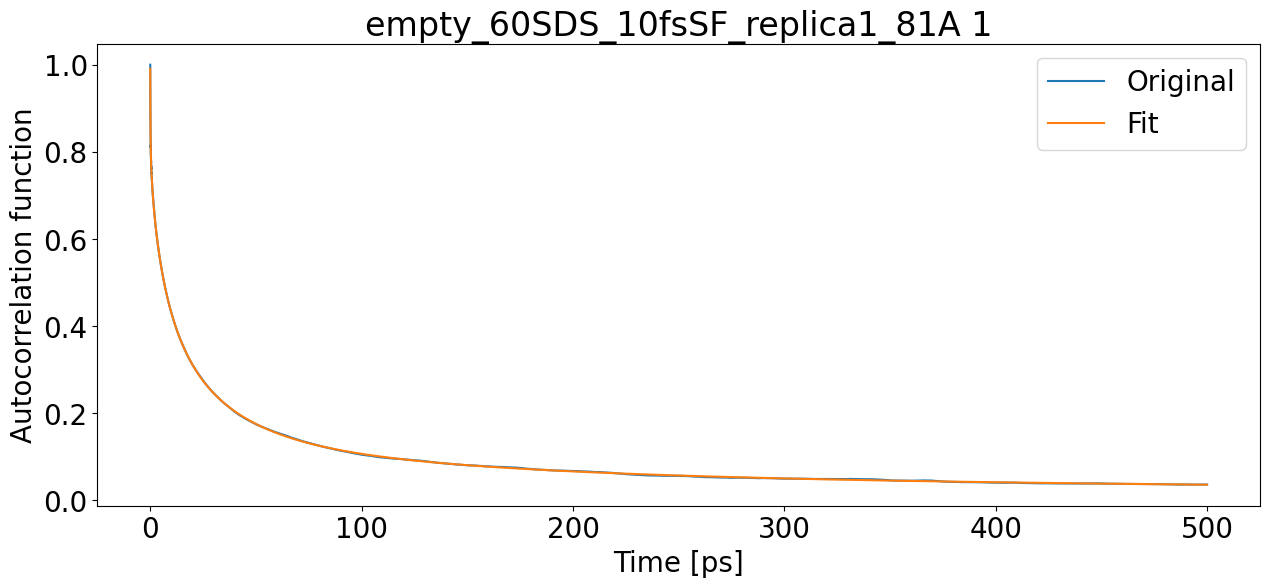

T1: 0.03851152451348444 T2: 0.033762069388387855 NOE: 0


In [ ]:
"""Analyze one system - the whole content of a folder"""
for magnetic_field in [2.35 , 5.99 , 8.49]: 
    aminoAcids=rt.analyze_all_in_folder(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,folder_path,nuclei,output_path_relax,output_path_timescales,output_name)

<h4>Option 3 - analyze different systems in a given parent_folder_path</h4>

In [12]:
"""Analyze many systems in a parent folder"""
calculated_systems={}
for file in os.listdir(parent_folder_path):
    folder_path = parent_folder_path+os.fsdecode(file)+"/"
    for system in systems:
        if fnmatch.fnmatch(os.fsdecode(file), "*"+system+"*"):
            calculated_systems[os.fsdecode(file)]=rt.analyze_all_in_folder(OP,smallest_corr_time, biggest_corr_time, N_exp_to_fit,analyze,magnetic_field,folder_path,nuclei,output_path_relax,output_path_timescales,output_name=None)
            

<h3>6) Plot results</h3>
<h4> Read in data</h4>
Reads in all the data that exists in "output_path_relax", and "output_path_timescales"

In [2]:
output_path_relax="../../CorysPeptides/relax_times_yamls/protein/averages/"            # folder to save spin relaxation times yaml files, 
                                      # defined above or redefine here 
output_path_timescales="../../CorysPeptides/timescales_yamls/protein/averages/"  # folder to save timescale yaml files
                                      # defined above or redefine here

relaxation_yamls,timescales_yamls=mf.load_yaml_files(output_path_relax,output_path_timescales)

Spin relaxation data exist for:

   * eElab_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_average
   * mag2_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_average
   * hMff_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_average
   * eYqJd_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_average
   * eElab_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_average
   * yFis1_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_average

 
Timescales exist for:

   * eElab_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_average
   * mag2_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_average
   * eYqJd_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_average
   * hMff_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_average
   * yFis1_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_average
   * eElab_micelle_50SDS_CHARMM_310K_Na_Neut_OPC_average


<h4> Check which analysis done</h4>
All the analysis done before are stored here, check and select which one you want to use

In [3]:
mf.what_analysis_done(timescales_yamls["hMff_45SDS_s"])

nuclei : 15N , analyzed in:  ['analysis0', 'analysis1']
*
magnetic_field_[T] : 19.964291496497925 , analyzed in:  ['analysis0', 'analysis1']
*
magnetic_field_[MHz] : 850.0 , analyzed in:  ['analysis0', 'analysis1']
*
N_exp_to_fit : 100 , analyzed in:  ['analysis0', 'analysis1']
*
smallest_corr_time_[s] : 1e-12 , analyzed in:  ['analysis0', 'analysis1']
*
biggest_corr_time_[s] : 1e-07 , analyzed in:  ['analysis0', 'analysis1']
*
analyze : 0.019230769230769232 , analyzed in:  ['analysis0']
analyze : 0.0196078431372549 , analyzed in:  ['analysis1']
*
OP : 0 , analyzed in:  ['analysis0', 'analysis1']
*
corr_func_length_[ps] : 5200.0 , analyzed in:  ['analysis0']
corr_func_length_[ps] : 5100.0 , analyzed in:  ['analysis1']
*
saving_frequency_[ps] : 10.0 , analyzed in:  ['analysis0', 'analysis1']
*
xtc : non-Water_eElab_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_replica2.xtc , analyzed in:  ['analysis0', 'analysis1']
*


<h4>6.1) Plot T1, T2, hetNOE relaxation data</h4>

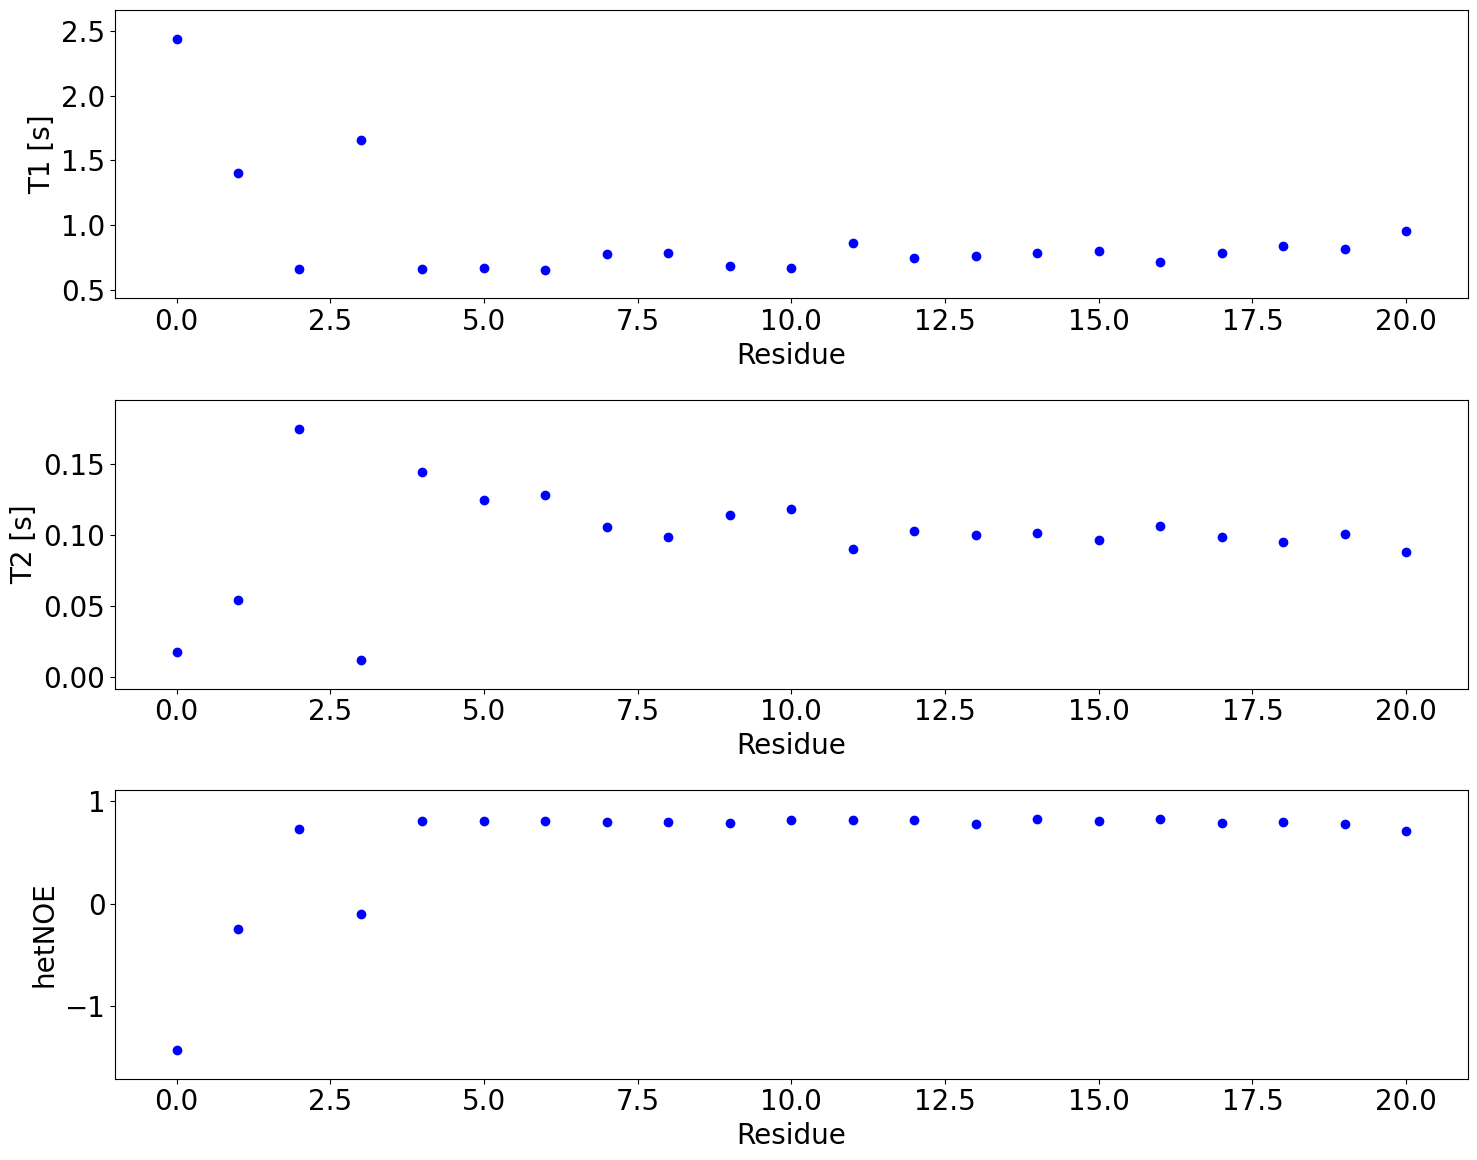

In [4]:
plot_output = "relax_times.pdf"   # name of the plot for saving
system =      "hMff_45SDS_s"        # system to be plotted
analysis =    "analysis0"         # analysis of the system to be plotted
pt.plot_T1_T2_noe(relaxation_yamls[system][analysis],plot_output)

<h4>6.2) Set y-axis range and categories to plot in different colors</h4>

In [16]:
merge=5 # number of consequent points to be merged (works on log scale!!)
groupTimes=[10**(-10),10**(-9),10**(-9)*5,10**(-8)] # groups points smaller than 1st value, 
                                                    #points between 1st and 2nd, 2nd and 3st....
                                                    #points bigger than the last value
ylim=[10**(-10),10**(-8)*2] # useful for observing details
ylim_weig=[0,1]
ylim=None # if None the whole range of available data is plotted
title="Time coefficients"
xlabel="Residue of hMff"
plot_output="time_scales.pdf"

<h4>6.2) Plot dynamics</h4>

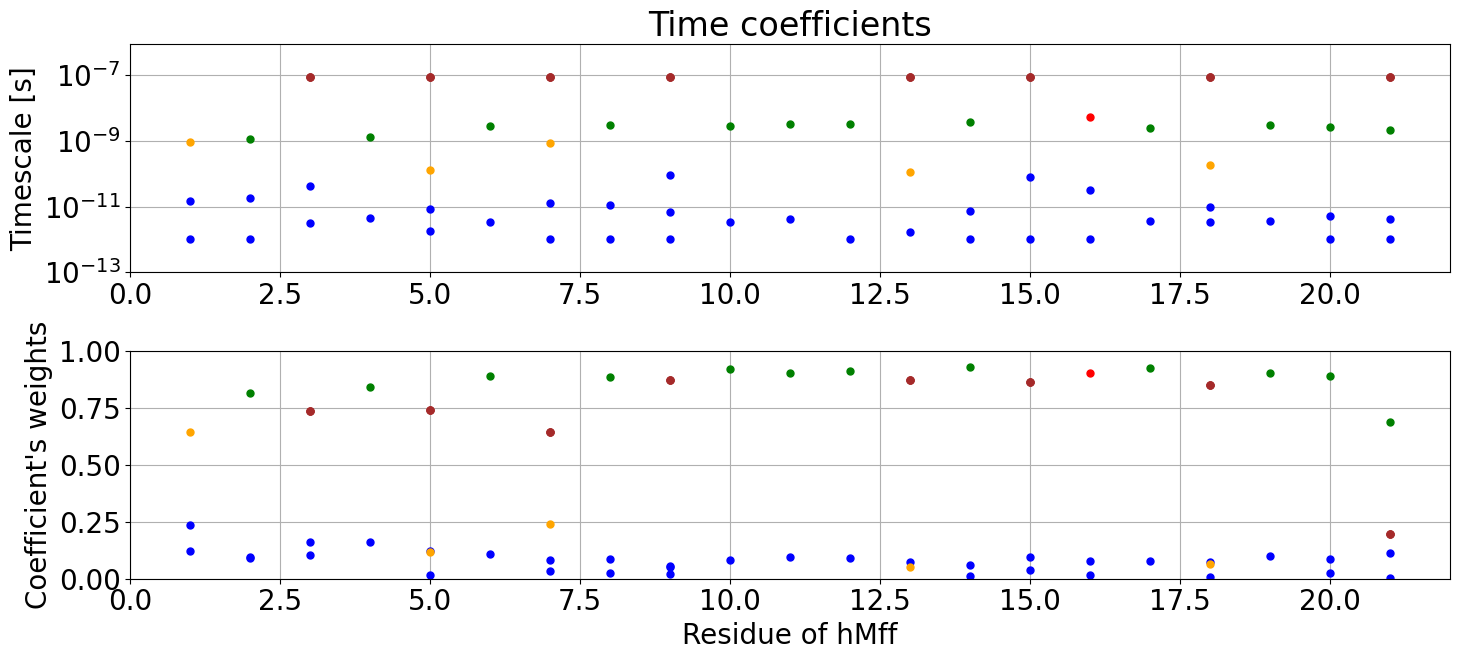

In [6]:
pt.PlotTimescales(timescales_yamls[system][analysis],merge,groupTimes,title,xlabel,ylim,ylim_weig,yscale,plot_output)

<h4>6.3) Plot of replicas</h4>

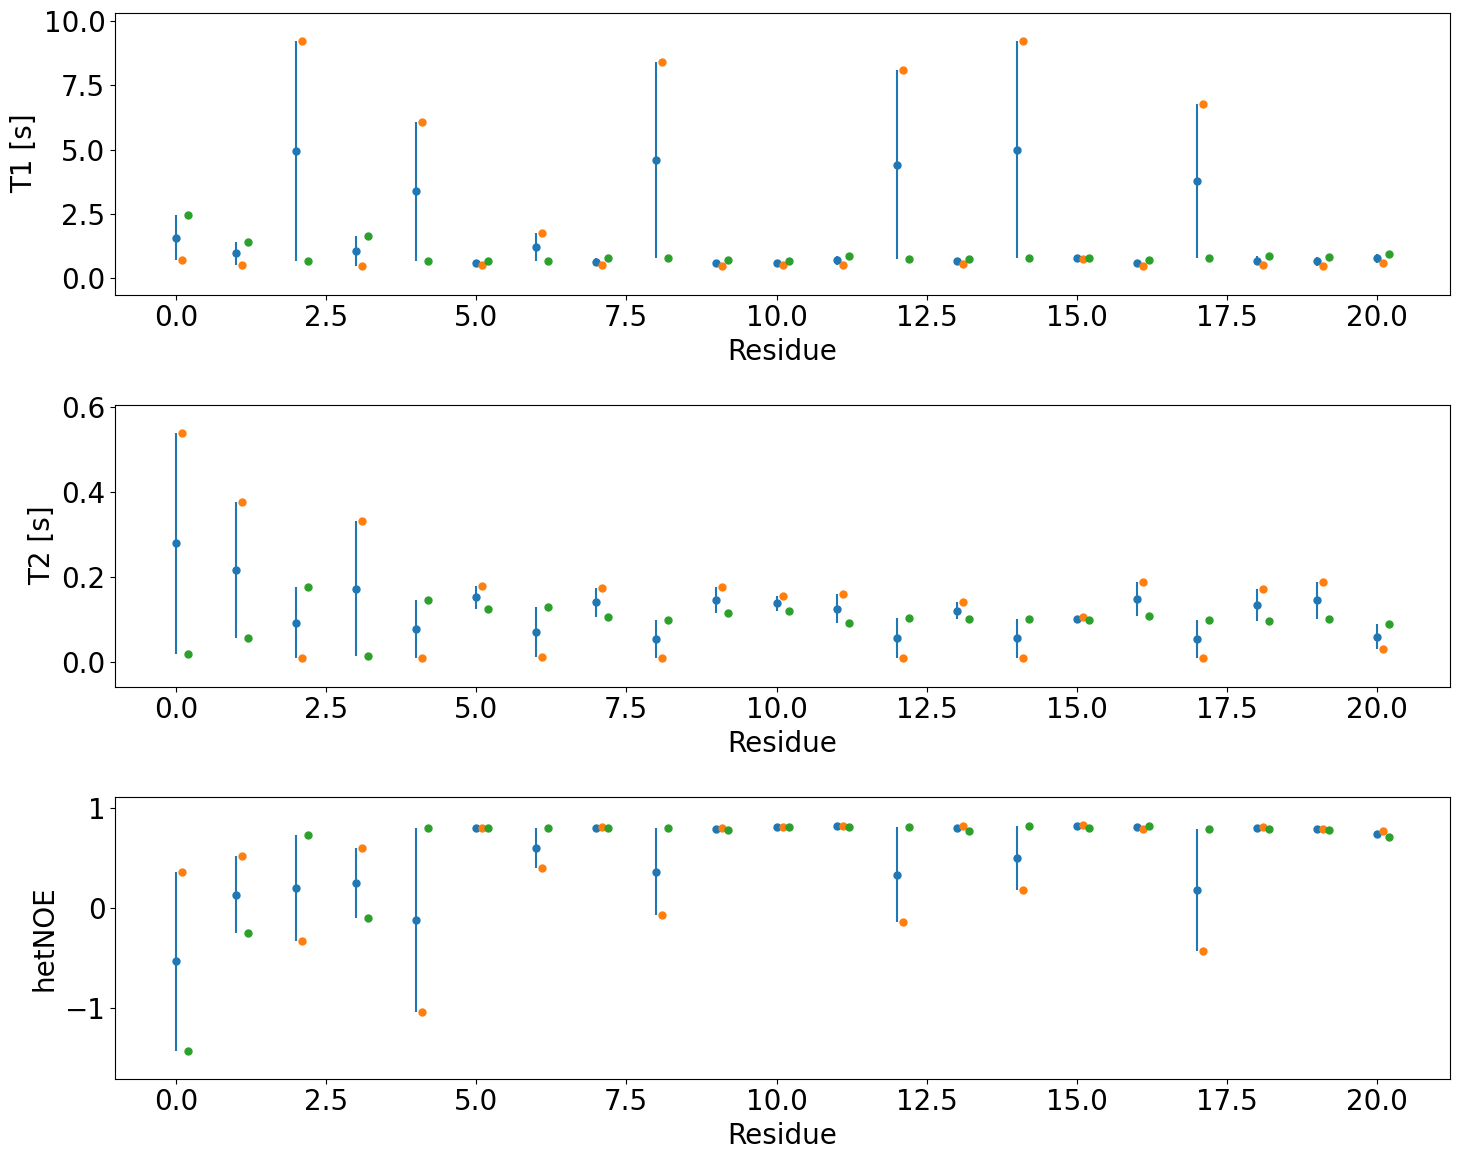

In [12]:
save_name="hMff_40_45_50_60SDS_850MHz.pdf"
plotType="average"   #average/all
                     # average - plot averages over "number" of replicas
                     # all - works with "number"==1 , plots all systems independently
number=2
system1=relaxation_yamls["hMff_45SDS_s"]["analysis0"]
system2=relaxation_yamls["non-Water_eElab_micelle_40SDS_CHARMM_310K_Na_Neut_OPC_replica2"]["analysis0"]
replicas=[system1,system2,system2,system2,system1,system1]
pt.plot_replicas(save_name,plotType,number,*replicas)

<h4>6.4) Plot of timescales for replicas</h4>

In [3]:
merge=5 # number of consequent points to be merged (works on log scale!!)
groupTimes=[10**(-10),10**(-9),10**(-9)*5,10**(-8)] # groups points smaller than 1st value, 
                                                    #points between 1st and 2nd, 2nd and 3st....
                                                    #points bigger than the last value
ylim=[0,10**(-8)*1] # useful for observing details
ylim_weig=[0,1]
#ylim=None # if None the whole range of available data is plotted
title="Timescales of AA of peptides in SDS micelles"
xlabel="Residue of a peptide"
plot_output="time_scales.pdf"
yscale="lin" #log/lin  logarithim/linear scale

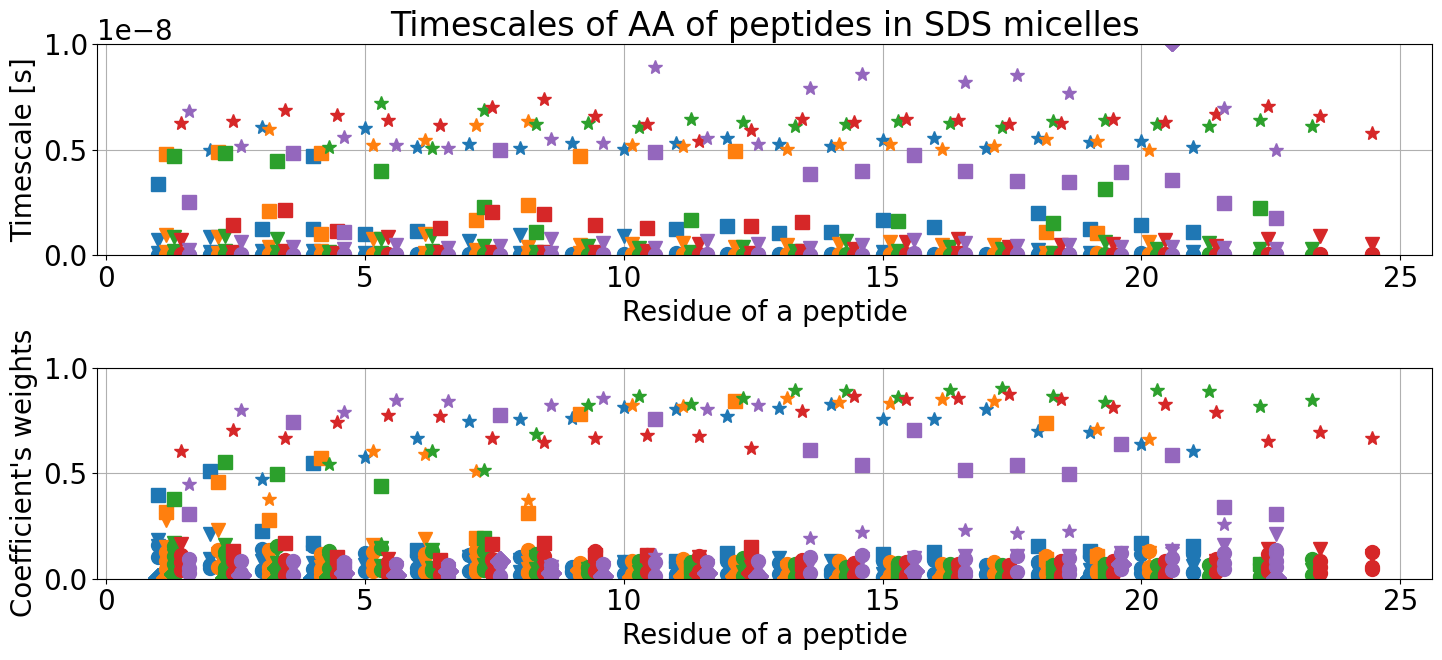

In [128]:
pt.PlotTimescales_replicas(merge,groupTimes,title,xlabel,ylim,ylim_weig,yscale,*aminoAcids)

<h4>6.5) Plot of timescales for replicas, second option</h4>

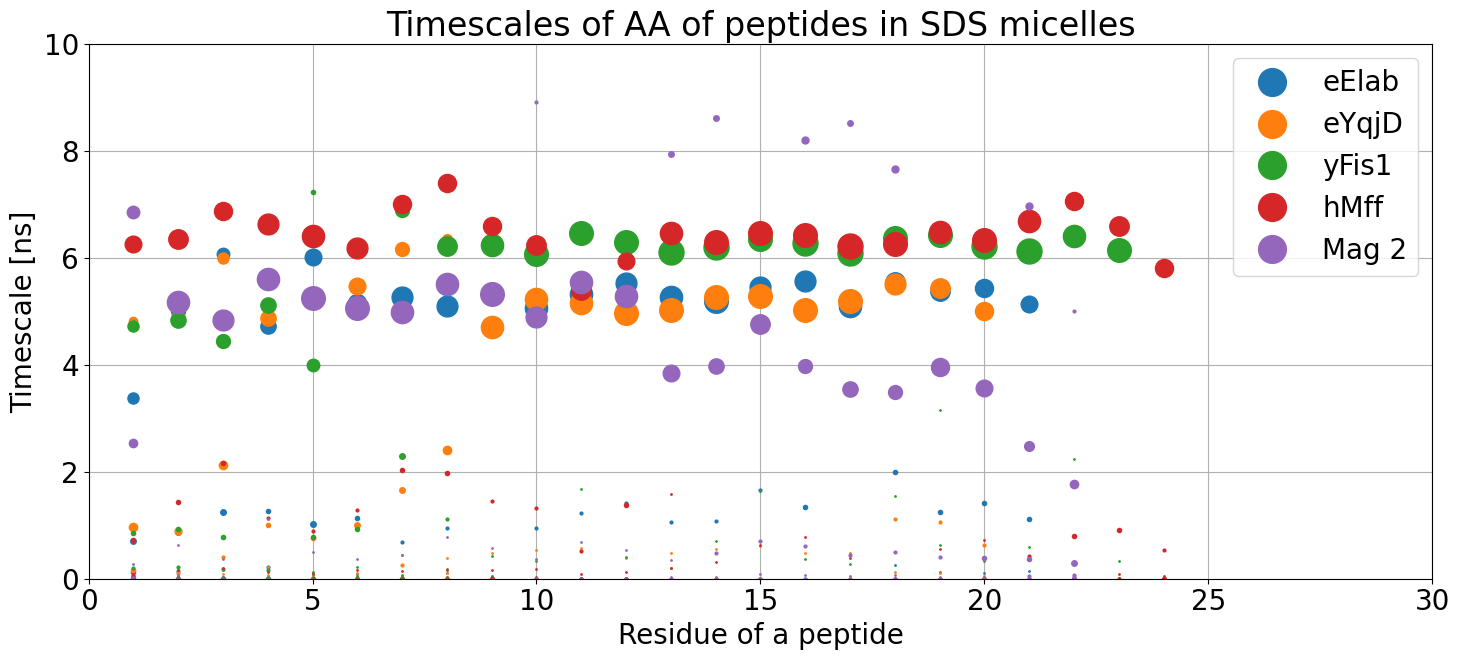

In [4]:
merge=5 # number of consequent points to be merged (works on log scale!!)
ylim=[0,10**(-8)*1] # useful for observing details
#ylim=None # if None the whole range of available data is plotted
title="Timescales of AA of peptides in SDS micelles"
xlabel="Residue of a peptide"
plot_output="time_scales.pdf"
yscale="lin" #log/lin  logarithim/linear scale
units=10**9 # 1- seconds, 10**3 ms, 10**6 us, 10**9 ns ...
shift=0 # shift points for different systems in x-axis, multiplies of 0.15

aminoAcidsReplicas=[]
for system in timescales_yamls:
    #print(system)
    aminoAcidsReplicas.append(timescales_yamls[system]["analysis0"])


labels=["eElab","eYqjD","yFis1","hMff","Mag 2"] #must have same dimention as aminoAcids
aminoAcids=[aminoAcidsReplicas[0],aminoAcidsReplicas[2],aminoAcidsReplicas[4],aminoAcidsReplicas[3],aminoAcidsReplicas[1]]

pt.PlotTimescales_replicas2(merge,shift,title,xlabel,ylim,yscale,units,labels,*aminoAcids)

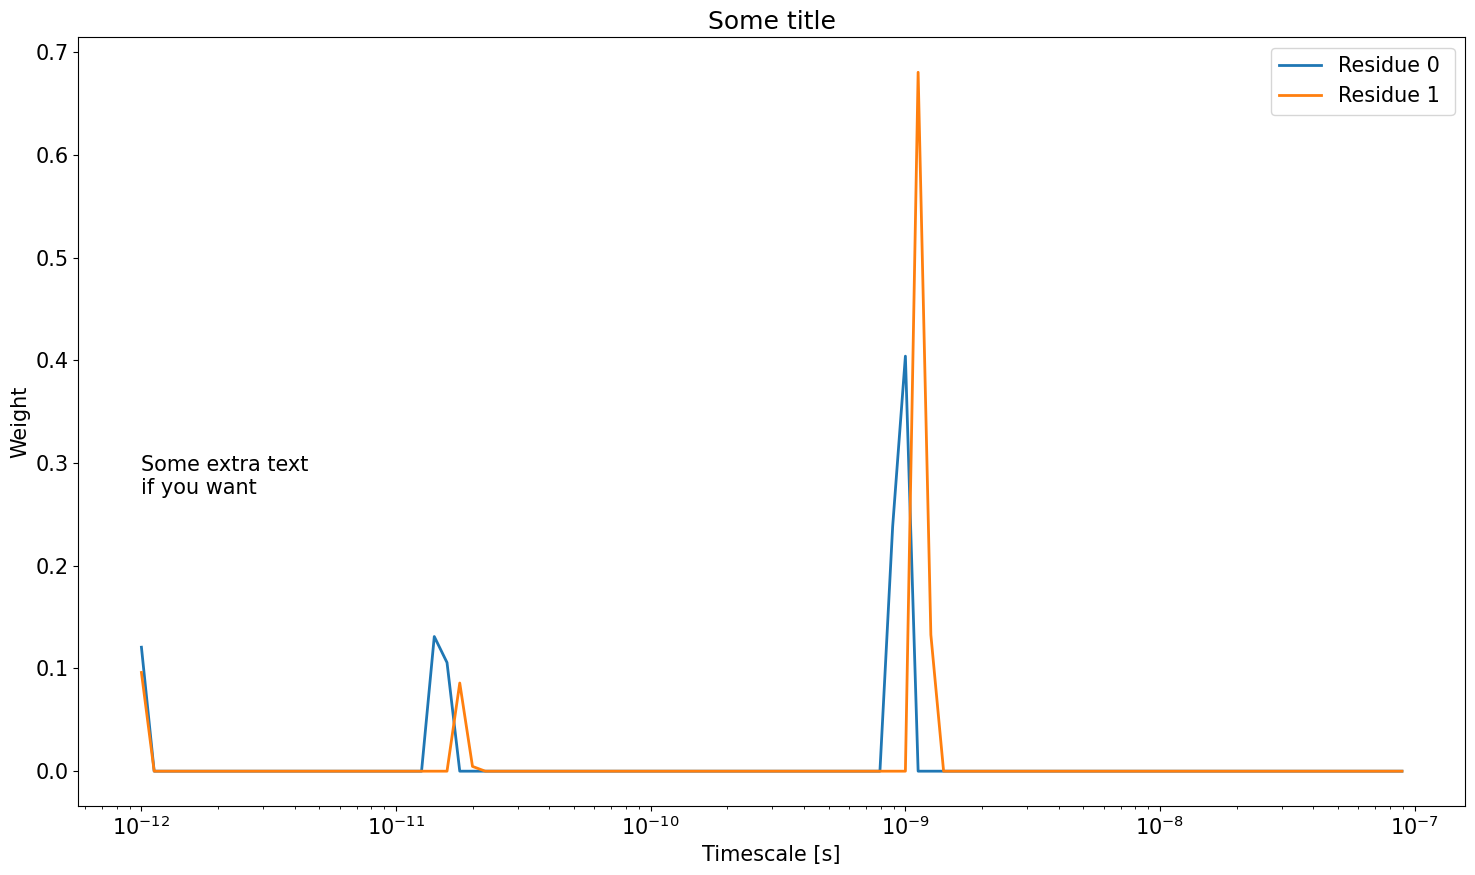

In [22]:
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')

plt.rcParams["figure.figsize"] = [15.00, 9]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 15})

plt.xscale("log")


plt.plot(timescales_yamls["hMff_45SDS_s"]["analysis1"]["results"]["Ctime"],timescales_yamls["hMff_45SDS_s"]["analysis1"]["results"]["Coeff"][0],lw=2,label="Residue 0 ")

plt.plot(timescales_yamls["hMff_45SDS_s"]["analysis0"]["results"]["Ctime"],timescales_yamls["hMff_45SDS_s"]["analysis0"]["results"]["Coeff"][1],lw=2,label="Residue 1 ")


plt.legend()

plt.ylabel("Weight")
plt.xlabel("Timescale [s]")

plt.title("Some title")

plt.text(10**(-12),0.27,"Some extra text \nif you want")

plt.savefig("python_matlab_RL_1st.pdf")

<center><h1>7) Spin relaxation times as a function of field and dynamics</h1></center>

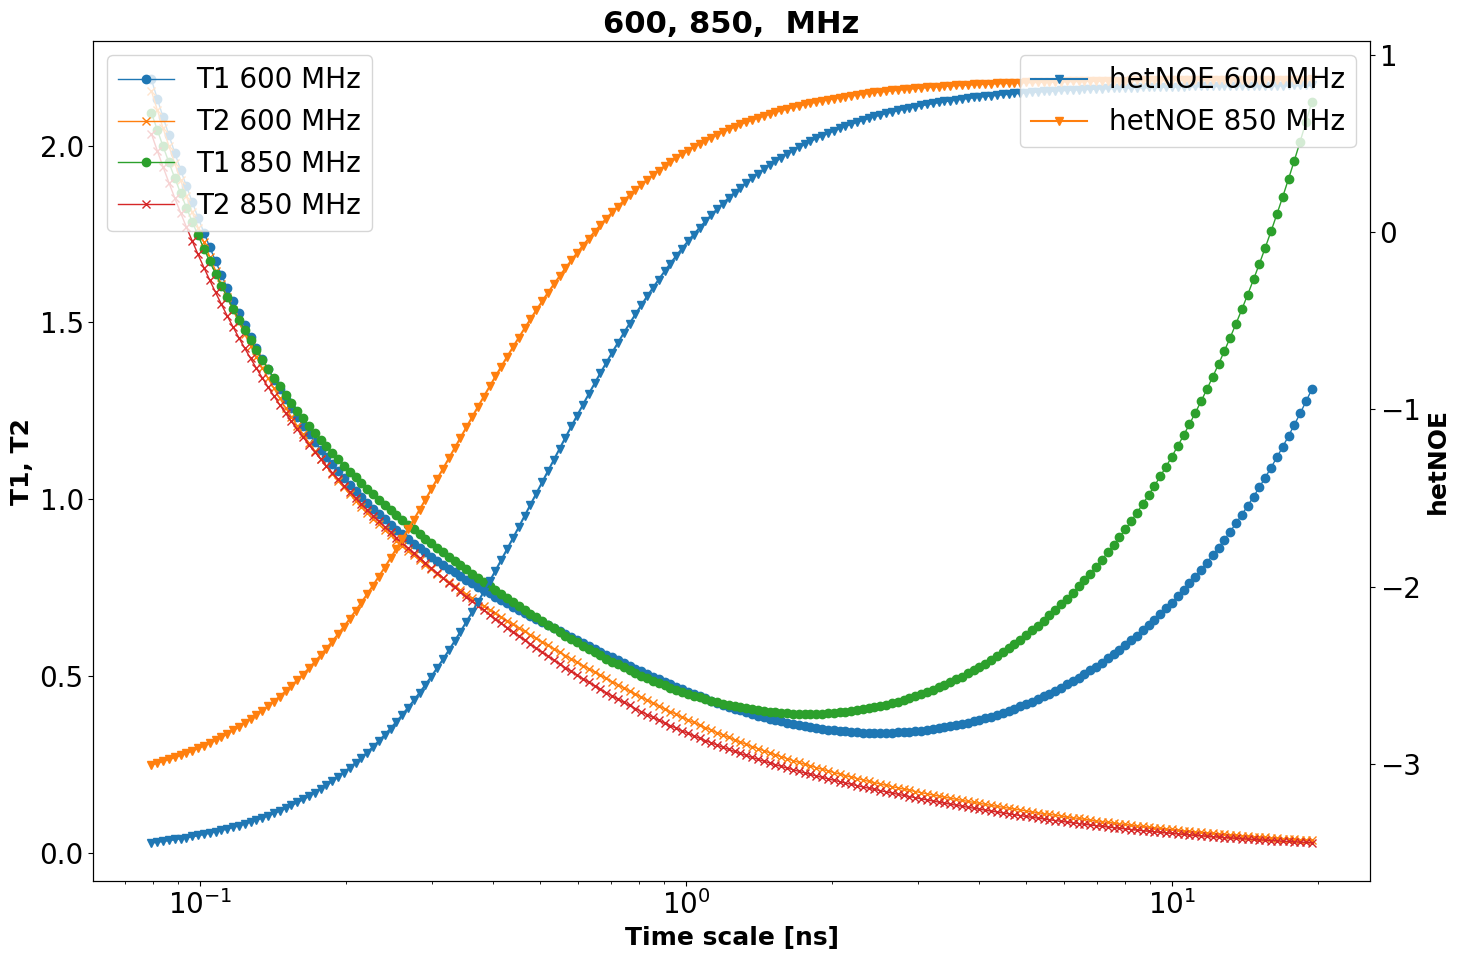

In [12]:
#plot relaxation times as a function of dynamics and magnetic field, only 2D plot, atm
magnetic_fields=[600,850]


smallest_corr_time=1.9 # enter in log scale -3 fs; 0 ps; 3 ns; 6 us;
biggest_corr_time=4.3 # same as above
N_exp_to_fit=200 # number of exponential functions to be fitted between the samlles and biggest corr time

step_exp=(biggest_corr_time-smallest_corr_time)/N_exp_to_fit
Ctimes = 10 ** np.arange(smallest_corr_time, biggest_corr_time, step_exp)
Ctimes = Ctimes * 0.001 * 10 ** (-9);

fig,ax = plt.subplots(figsize=(15, 10))
ax.set_xlabel("Time scale [ns]",fontsize=18, weight = 'bold')
ax.set_ylabel("T1, T2",fontsize=18, weight = 'bold')
ax.set_xscale('log')
ax2=ax.twinx()
ax2.set_ylabel("hetNOE",fontsize=18, weight = 'bold')
ax2.set_xscale('log')


title=""
for magn_field in magnetic_fields:
    magnetic_field=magn_field*2*np.pi/gammaH*10**6
    
    T1=[]
    T2=[]
    NOE=[]
    for time_scale in Ctimes:
        t1, t2, noe = rt.get_relaxation_N(magnetic_field,[1],[time_scale],OP)
        T1.append(t1)
        T2.append(t2)
        NOE.append(noe)
        
    
    ax.plot(Ctimes*10**9,T1,label="T1 " + str(magn_field)+ " MHz",  marker="o", linewidth=1.0)
    ax.plot(Ctimes*10**9,T2,label="T2 " + str(magn_field)+ " MHz",   marker="x", linewidth=1.0)
    
    
    ax2.plot(Ctimes*10**9,NOE,label="hetNOE " + str(magn_field)+ " MHz",marker="v")
    title+= str(magn_field) + ", "
    

ax.set_title(str(title)+ " MHz",fontsize=22, weight = 'bold')
ax2.legend(loc='upper right')

ax.legend(loc='upper left')
plt.show()